# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm.notebook import tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250708_qsim' # for data #also update data path in hardware_config_202505.yml
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250708_qsim


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')
print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data


In [4]:
#Hardware config
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

#Expt config
exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [5]:
#Set qubit (adopted from QRAM)
qubit_i = 0
import yaml
print(yaml)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)
print('yaml_cfg: \n', yaml_cfg)

<module 'yaml' from 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\yaml\\__init__.py'>
yaml_cfg: 
 {'device': {'qubit': {'T1': [277.39755232213906], 'f_ge': [3567.340096037547], 'f_ef': [3423.9707763531014], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [10748], 'sigma': [0.035], 'length': [0.0], 'type': 'gauss'}, 'hpi_ge': {'gain': [5003], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ef': {'gain': [9161], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'hpi_ef': {'gain': [4325], 'sigma': [0.035], 'type': 'gauss'}}, 'T1_ef': [167.85602598963504]}, 'readout': {'trig_offset': 450, 'frequency': [748.8941512875441], 'gain': [800], 'phase': [73.69187754633023], 'threshold': [-298.9150578233093], 'threshold_list': [[-298.9150578233093]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [7]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x14dc1968b50; not connected; for PYRO:obj_085aeae8385e4f2981f71cc89e2b2bab@192.168.137.101:37863>


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [9]:
# soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
# print(soc)

In [10]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host='192.168.137.25', ns_port=9090, proxy_name='Qick101')
# print(soccfg)

In [11]:
# from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host=“171.64.84.155”, ns_port=9090, proxy_name=“QickESR”)
# print(soccfg)

## Choose experiment name

In [12]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'C:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [13]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

## Datset for Sidebands

In [21]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.994347              NaN   0.917427    0.445843   
1      M1-S2   520.361274              NaN   1.084582    0.539466   
2      M1-S3   696.094677              NaN   1.314576    0.658091   
3      M1-S4   874.815379              NaN   1.221390    0.613439   
4      M1-S5  1053.097573              NaN   1.595772    0.802749   
5      M1-S6  1245.006393              NaN   1.253407    0.619833   
6      M1-S7  1422.461718              NaN   2.293646    1.144853   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2005.850000              NaN   1.079883    0.530253   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.426206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-06-30 02:15:15.104235  
1               5000  2025-06-30 02:18:13.425128  
2               9000  2025-06-30 02:21:12.434147  
3               9000  2025-06-30 02:24:10.686562  
4               7500  2025-06-30 02:27:09.054687  
5              13500  2025-06-30 02:30:07.599645  
6              10000  2025-06-30 02:33:06.360285  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-07-08 14:54:59.611517  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [15]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [16]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.manipulate

{'f_ge': [4984.517099141256, 5157.8527963217475],
 'displace_sigma': [0.05, 0.05],
 'revival_time': [1.584663918482869, 1.7366205852286094],
 'gain_to_alpha': [0.0002753329059097354, 0.00020045],
 'freq_to_alpha': [0.495062203431879, 0.0],
 'chi_ge': [-0.2725917475648555],
 'chi_ef': [-0.24480332166390534],
 'ramp_sigma': 0.005}

In [17]:
expts_to_run = {# readout 
                'res_spec': True, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': True,
                't2_ge': True, 
                'amplitude_ge': True,
                't1_ge': False,
                # qubit ef
                'pulse_probe_ef': True,
                't2_ef': True,
                'amplitude_ef': True,
                't1_ef': False,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': True,
                'length_rabi_sweep':True,
                'length_rabi':False, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': True, 
                'chi_ef': True,
                'RB': False,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': True,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [18]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\autocalibration_plots_2025-07-08


## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [19]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    rspec.cfg.expt = dict(
        start = 746.5, # resonator frequency to be mixed up [MHz]
        step = 0.02, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 500, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

  0%|          | 0/250 [00:00<?, ?it/s]

[748.99, 5000, 1000, 0, 657.5923210779467, 255.63831315110556, 2.5944632520704625]
[ 748.89707444 -200.15996659  276.72162534   -1.5323957   272.66764412
  831.24483742  -49.22611767]

Freq with minimum transmission: 747.62
Freq with maximum transmission: 749.1
From fit:
	f0: 748.8970744402941
	Qi: -200.1599665904603
	Qe: 276.72162533775986
	Q0: -723.4507740392646
	kappa [MHz]: -1.0351735063589114
	phi [radians]: -1.532395695835293
Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00007_ResonatorSpectroscopyExperiment.h5


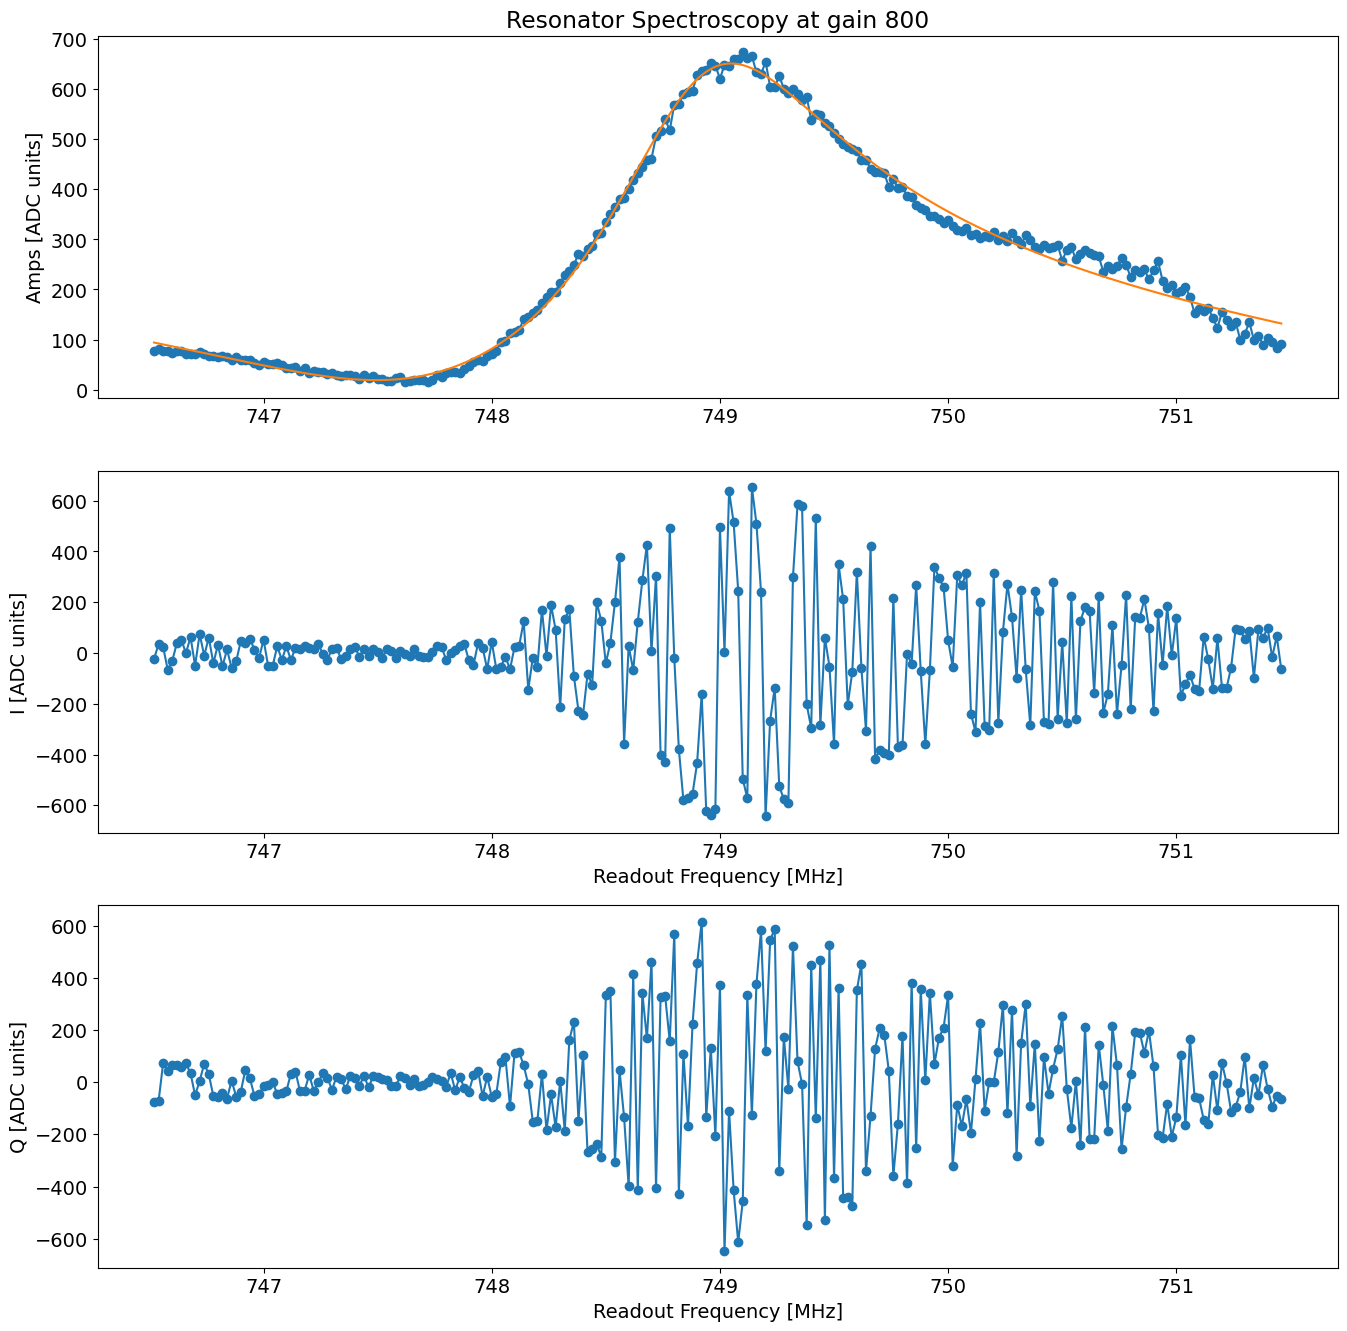

In [20]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec(config_thisrun=config_thisrun)

In [21]:
rspec.data['fit'][0]

748.8970744402941

In [22]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

Updated readout frequency!
Resonator spectroscopy done!


## Single Shot

In [19]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=250
):
    """Run the single shot experiment with configurable parameters."""

    # if pre_sweep_pulse is None:
    #     pre_sweep_pulse = [
    #         ['qubit', 'ge', 'pi', 0],
    #     ]

    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=800, threshold=None, config=hstgrm.cfg,
        )
    return hstgrm, hist_analysis


def update_single_shot(hist_analysis, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hist_analysis.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hist_analysis.data['Ig_rot'])
    if hist_analysis.cfg.expt.active_reset:
        config_thisrun.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [20]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path, reps = 5000, active_reset=False, relax_delay = 2500)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00003_HistogramExperiment.h5
{'device': {'qubit': {'T1': [277.39755232213906], 'f_ge': [3567.3506008394015], 'f_ef': [3423.990931159239], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [10748], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [5003], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [9161], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [4325], 'sigma': [0.035], 'type': ['gauss']}}, 'T1_ef': [167.85602598963504]}, 'readout': {'trig_offset': [450], 'frequency': [748.8941512875441], 'gain': [800], 'phase': [73.4451705076109], 'threshold': [-283.43264261118475], 'threshold_list': [[-283.43264261118475]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0.986

Unrotated:
Ig -508.538961038961 +/- 77.16901385530244 	 Qg -395.00108225108227 +/- 56.96422908486052 	 Amp g 643.923698798322
Ie 34.361471861471856 +/- 125.0389585293884 	 Qe -397.3387445887446 +/- 68.19606921046896 	 Amp e 398.82175053505586
updating temp data
Rotated:
Ig -506.9150578233092 +/- 77.23989126573207 	 Qg -397.19616430309793 +/- 56.86808676129533 	 Amp g 643.9935316329679
Ie 35.96504172330171 +/- 125.03719690029656 	 Qe -397.1801245086916 +/- 68.19929909602924 	 Amp e 398.8051347850208


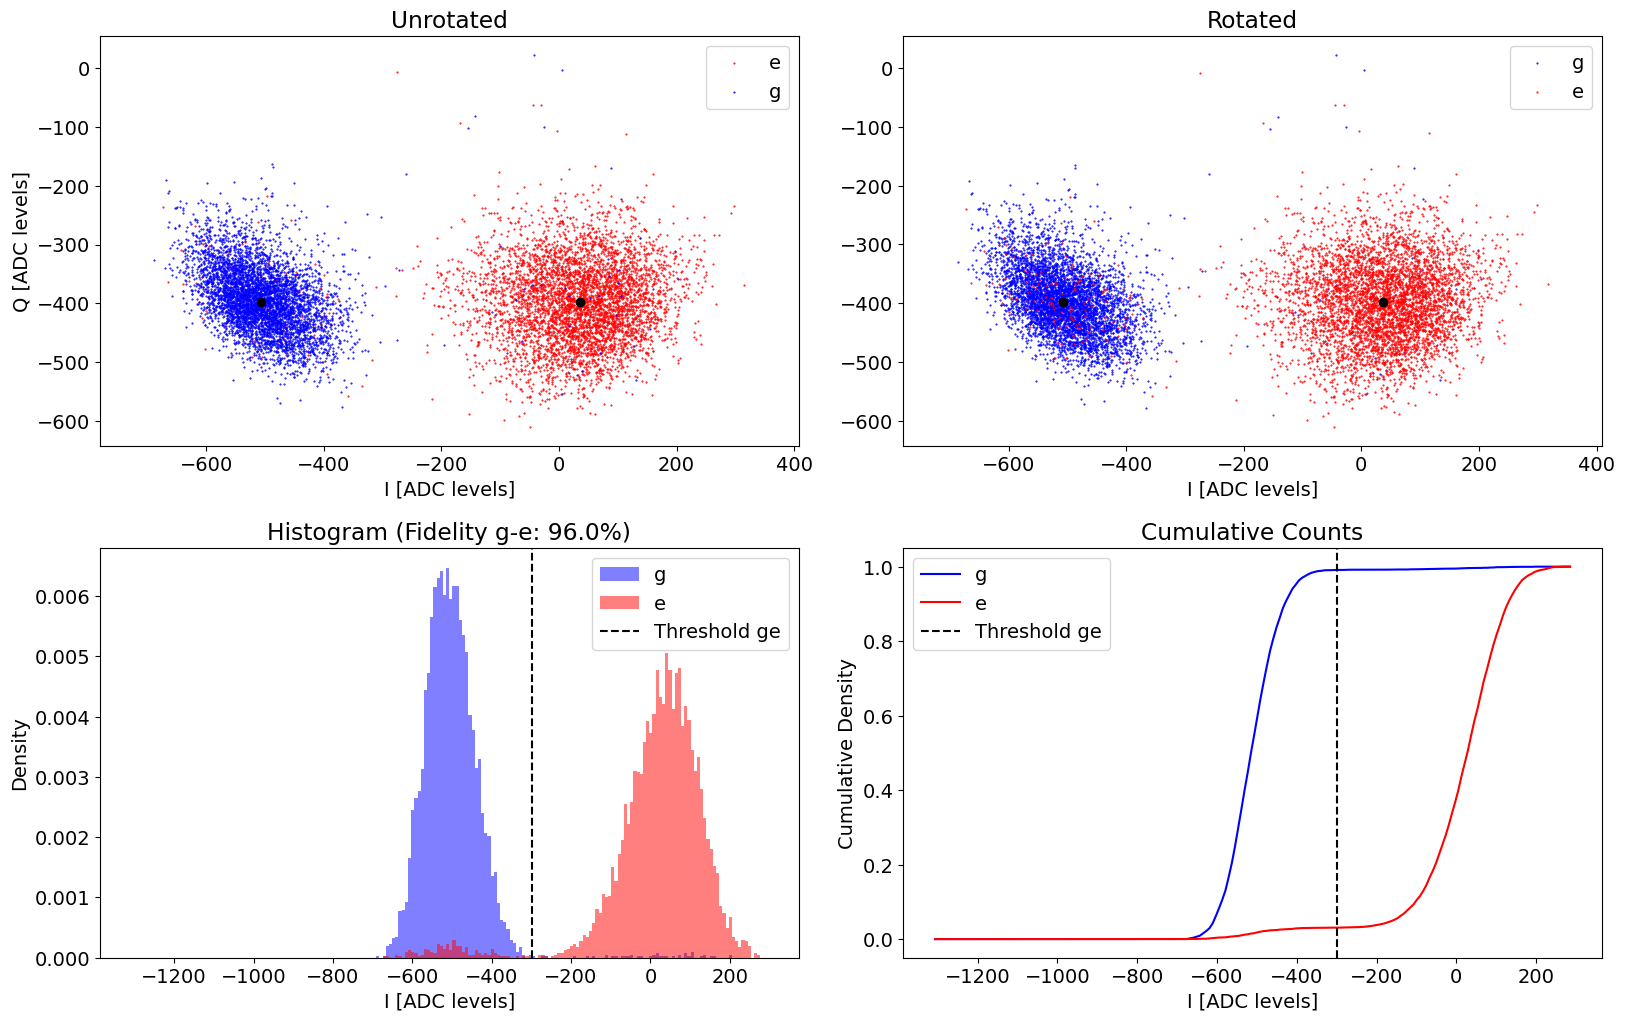

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_11-49-46_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md


In [21]:
hstgrm[1].analyze(plot = True)

In [22]:
config_thisrun.device.readout

{'trig_offset': 450,
 'frequency': [748.8941512875441],
 'gain': [800],
 'phase': [73.4451705076109],
 'threshold': [-283.43264261118475],
 'threshold_list': [[-283.43264261118475]],
 'man1_drive_list': [0.0],
 'man2_drive_list': [0.0],
 'readout_length': [1.5],
 'relax_delay': [2500],
 'confusion_matrix_with_reset': [0.9964530022802125,
  0.0035469977197875036,
  0.013768302080657598,
  0.9862316979193424],
 'confusion_matrix_without_reset': [0.9912,
  0.00880000000000003,
  0.02039999999999999,
  0.9796],
 'Ie': 36.44400085547777,
 'Ig': -507.43264261118486}

Unrotated:
Ig -508.538961038961 +/- 77.16901385530244 	 Qg -395.00108225108227 +/- 56.96422908486052 	 Amp g 643.923698798322
Ie 34.361471861471856 +/- 125.0389585293884 	 Qe -397.3387445887446 +/- 68.19606921046896 	 Amp e 398.82175053505586
updating temp data
Rotated:
Ig -506.9150578233092 +/- 77.23989126573207 	 Qg -397.19616430309793 +/- 56.86808676129533 	 Amp g 643.9935316329679
Ie 35.96504172330171 +/- 125.03719690029656 	 Qe -397.1801245086916 +/- 68.19929909602924 	 Amp e 398.8051347850208


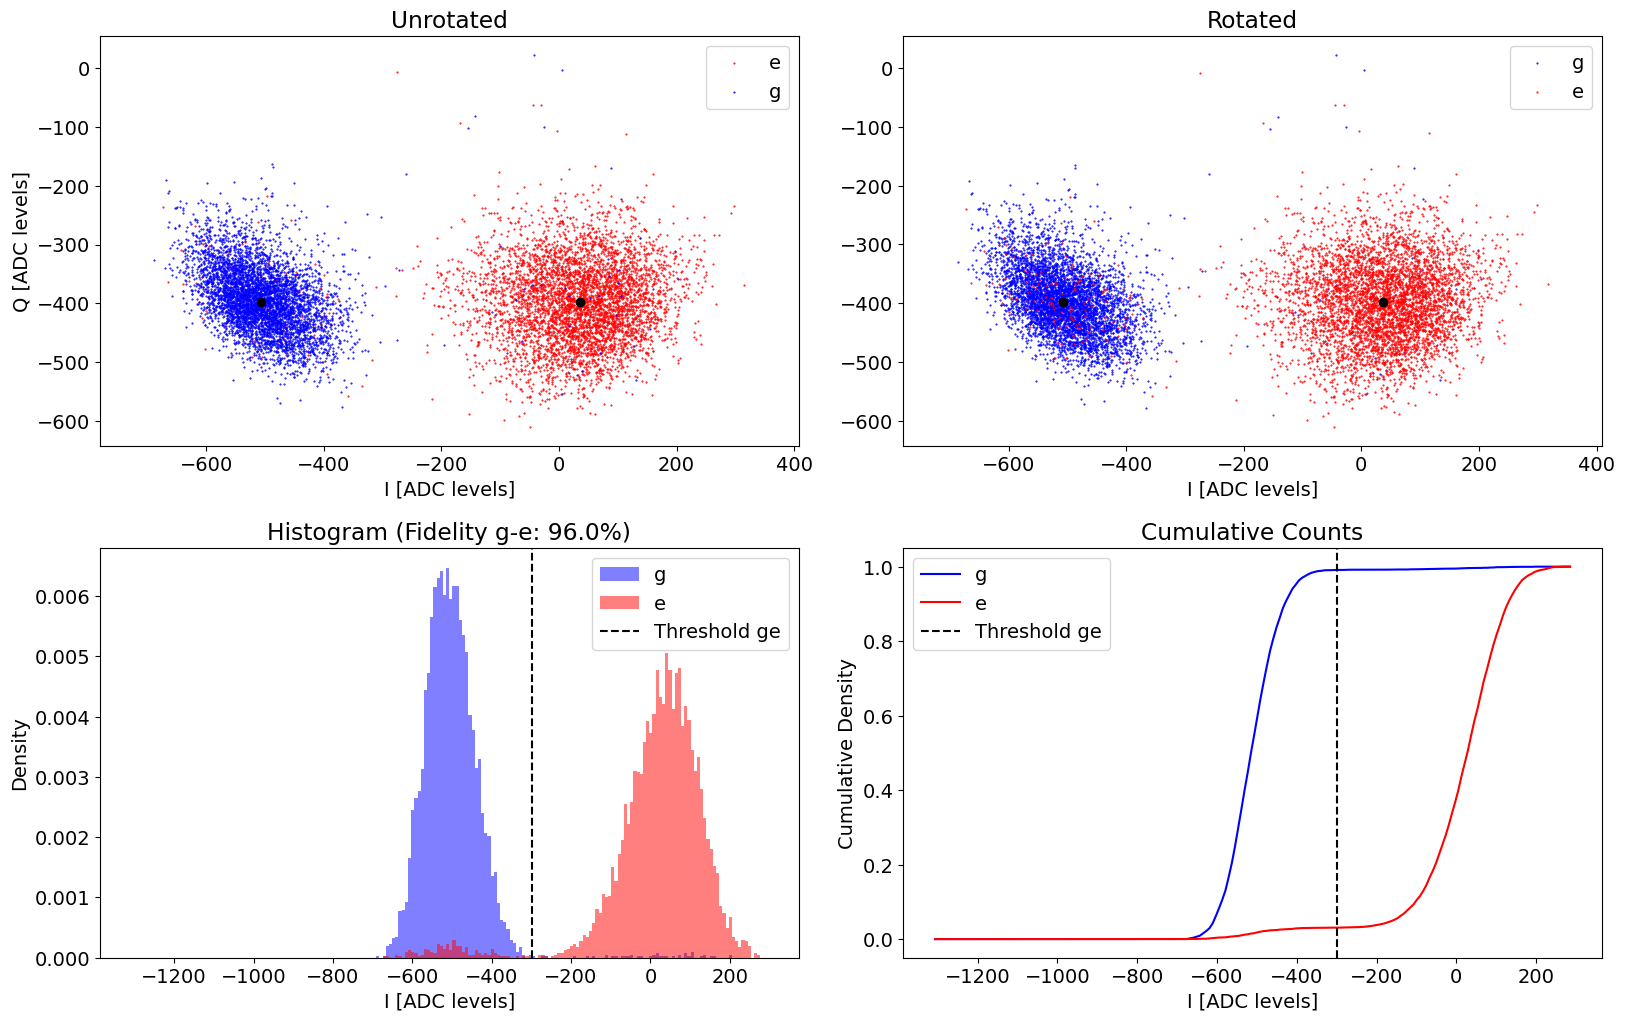

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_11-49-48_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
[0.9603815089053428]
Updated readout!
Single shot done!


In [23]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm[1], config_thisrun)
    print('Single shot done!')

In [28]:
# hstgrm.cfg

### JPA Calibration

In [29]:
def do_jpa_current_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=-8,
    jpa_current_step=0.1,
    jpa_current_stop = -2,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
    }

   
    class_for_exp.yaml_cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

In [30]:
# sweep_func = do_jpa_current_sweep(config_thisrun, expt_path, config_path, reps=1000, jpa_current_start=-5, jpa_current_step=0.03, jpa_current_stop=5)

## Qubit ge

### Pulse-probe

In [31]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

pulssing on channel:  2
qubit register page: 1, frequency register: 22


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00007_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3567.235257411222, HWHM 3.700826586172897
Found peak in I at [MHz] 3567.2424397257428, HWHM 3.5025491963871356
Found peak in Q at [MHz] 3567.545432665771, HWHM 3.1947351120996776


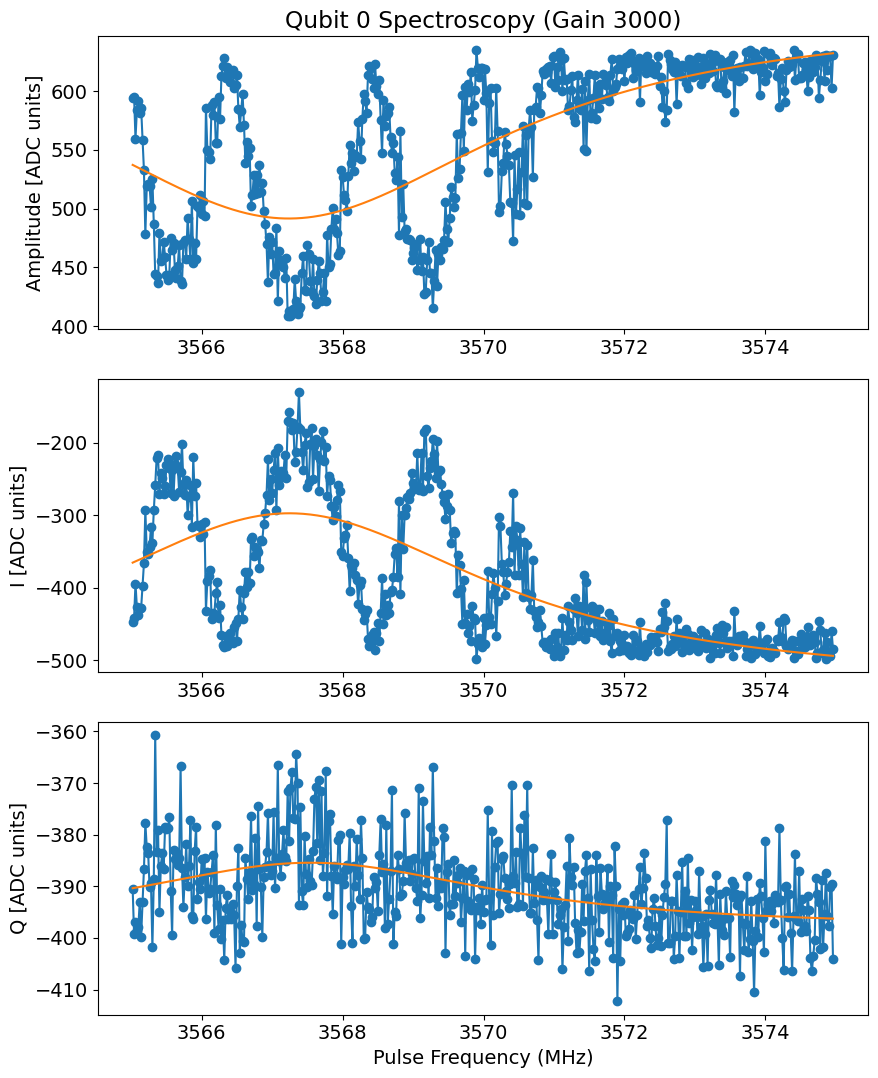

In [32]:
qspec =  do_pulse_probe(
    config_thisrun=config_thisrun,
    start=3565,  # [MHz]
    step=0.02,  # min step ~1 MHz
    expts=500,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=3000,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=300  # Wait time between experiments [us]
)

In [33]:
# if expts_to_run['pulse_probe_ge']: 
#     qspec = do_pulse_probe_ge(config_thisrun)

In [34]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

Updated qubit frequency!
Pulse probe spectroscopy done!


### T2 Ramsey

In [24]:
def do_t2_ramsey_ge(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=0.2,
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=200,
    ramsey_freq=0.2,  # [MHz]
    reps=200,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=True,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=200
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    # t2ramsey.cfg.device.qubit.f_ge = [3567.346809921427]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis



def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



fge is  3567.3506008394015
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00000_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3567.3506008394015
Fit frequency from I [MHz]: 0.21050480185458567 +/- 0.00023073588796343892
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.340096037547
 	3567.761105641256
T2 Ramsey from fit I [us]: 119.3734978324562
Fit frequency from Q [MHz]: 0.20998526002038617 +/- 0.0014056902931781844
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.340615579381
 	3567.7605860994217
T2 Ramsey from fit Q [us]: 36.382387286704756


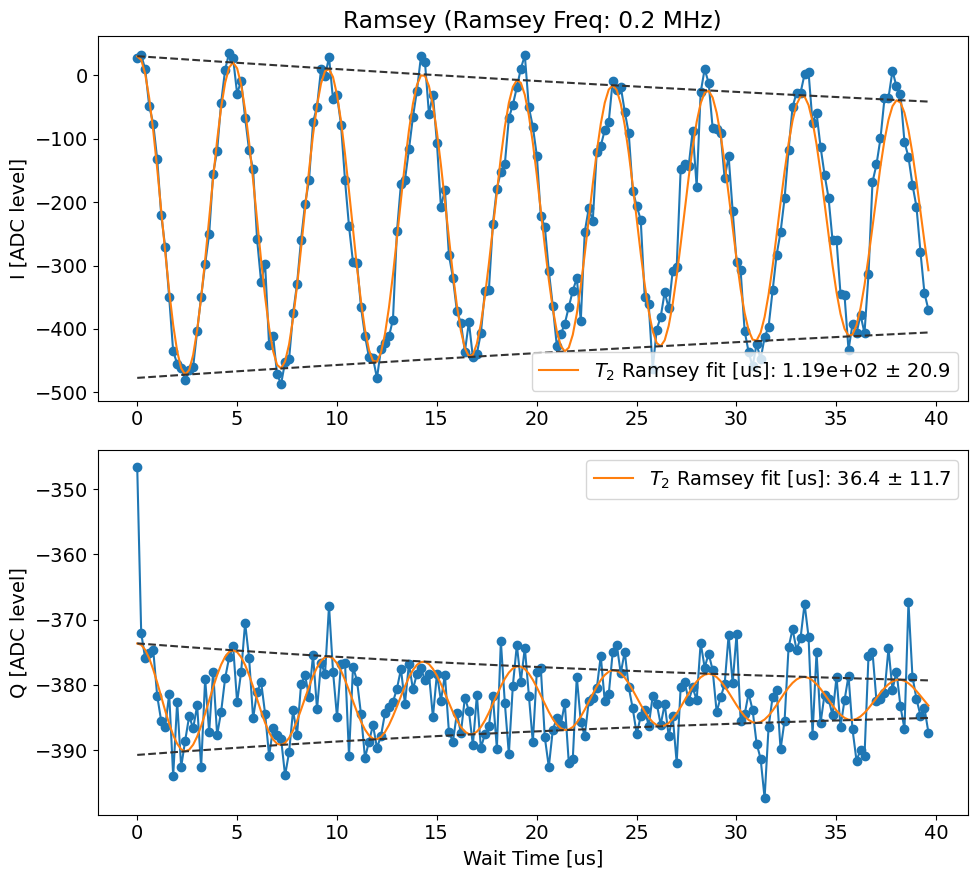

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_13-35-10_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
T2 Ramsey done!


In [25]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    # pre_sweep_pulse = [
    #     ['qubit', 'ge', 'pi', 0],
    #     ['qubit', 'ef', 'pi', 0],
    #     ['man', 'M1', 'pi', 0],
    # ]
    pre_sweep_pulse = None
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, step_size=0.2, pre_sweep_pulse=pre_sweep_pulse,
                                  active_reset = False, relax_delay=2500)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    print('T2 Ramsey done!')

In [28]:
if expts_to_run['t2_ge']:
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey updated!')

Updated qubit ge frequency to: 3567.340096037547
T2 Ramsey updated!


In [38]:
# idata = t2ramsey_ge.data['idata']
# idata = idata.reshape((len(idata)//4,4))

# qdata = t2ramsey_ge.data['qdata']
# qdata = qdata.reshape((len(qdata)//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

In [39]:
# t2ramsey_ge.analyze() #fitparams=[500, 10, None, 200, None, None])
# t2ramsey_ge.display(title_str='T2_ge')

In [40]:
# config_thisrun.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [104]:
def do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef = False):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_init = True

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=200,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_init,
        checkZZ=False,
        checkEF=checkEF,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [105]:
amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)

  0%|          | 0/30200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00023_AmplitudeRabiExperiment.h5


Attempted to init fitparam 4 to -197.48484220779218, which is out of bounds -454.13430735930734 to -359.5449891774892. Instead init to -406.83964826839826
Attempted to init fitparam 4 to -406.83964826839826, which is out of bounds 364.34294430068144 to 628.5739978638029. Instead init to 496.45847108224217
Pi gain from avgi data [dac units]: 10542
	Pi/2 gain from avgi data [dac units]: 4893
Pi gain from avgq data [dac units]: 159124
	Pi/2 gain from avgq data [dac units]: 99524


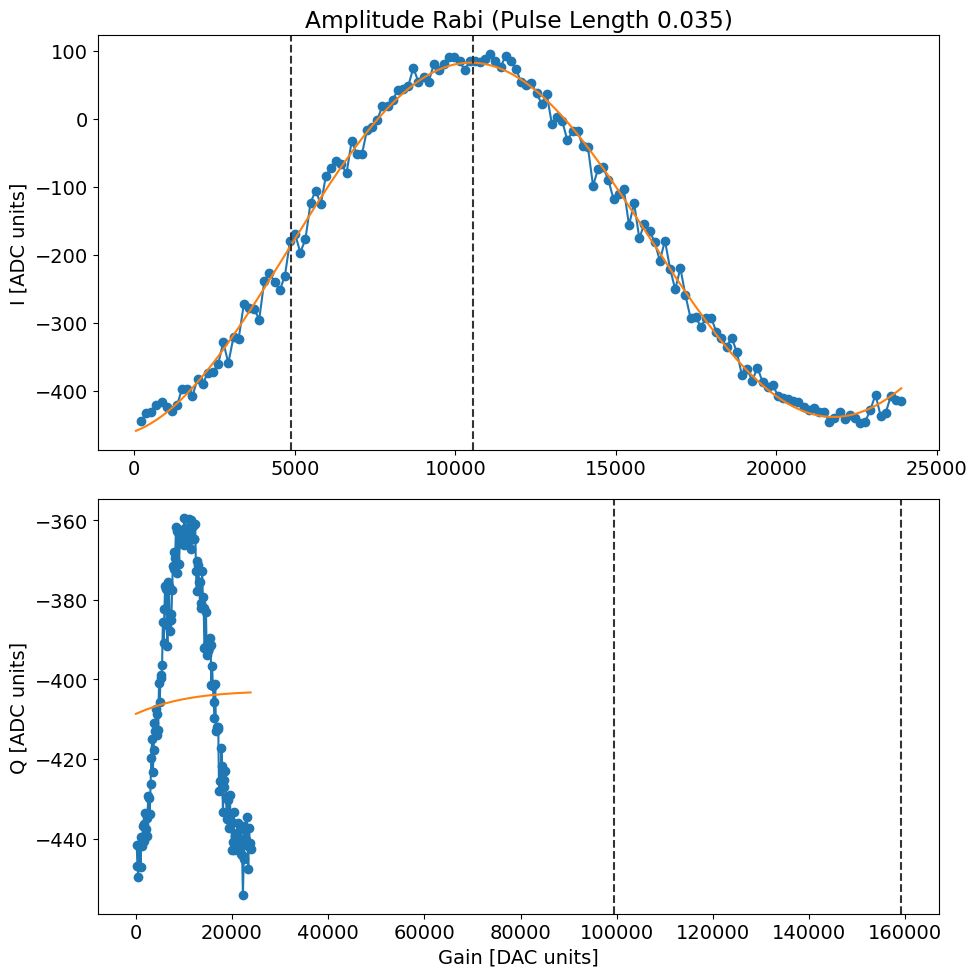

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_09-24-30_Amplitude_Rabi_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated qubit ge pi and hpi gaussian gain!


In [106]:
amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
update_amplitude_rabi(amprabi, config_thisrun)

  0%|          | 0/30200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00018_AmplitudeRabiExperiment.h5
Attempted to init fitparam 4 to -240.35057626262628, which is out of bounds -405.774512987013 to -359.7875757575757. Instead init to -382.78104437229433
Attempted to init fitparam 4 to -382.78104437229433, which is out of bounds 361.8514784003006 to 626.6514661624743. Instead init to 494.25147228138746
Pi gain from avgi data [dac units]: 10498
	Pi/2 gain from avgi data [dac units]: 4844
Pi gain from avgq data [dac units]: 153846
	Pi/2 gain from avgq data [dac units]: 94246


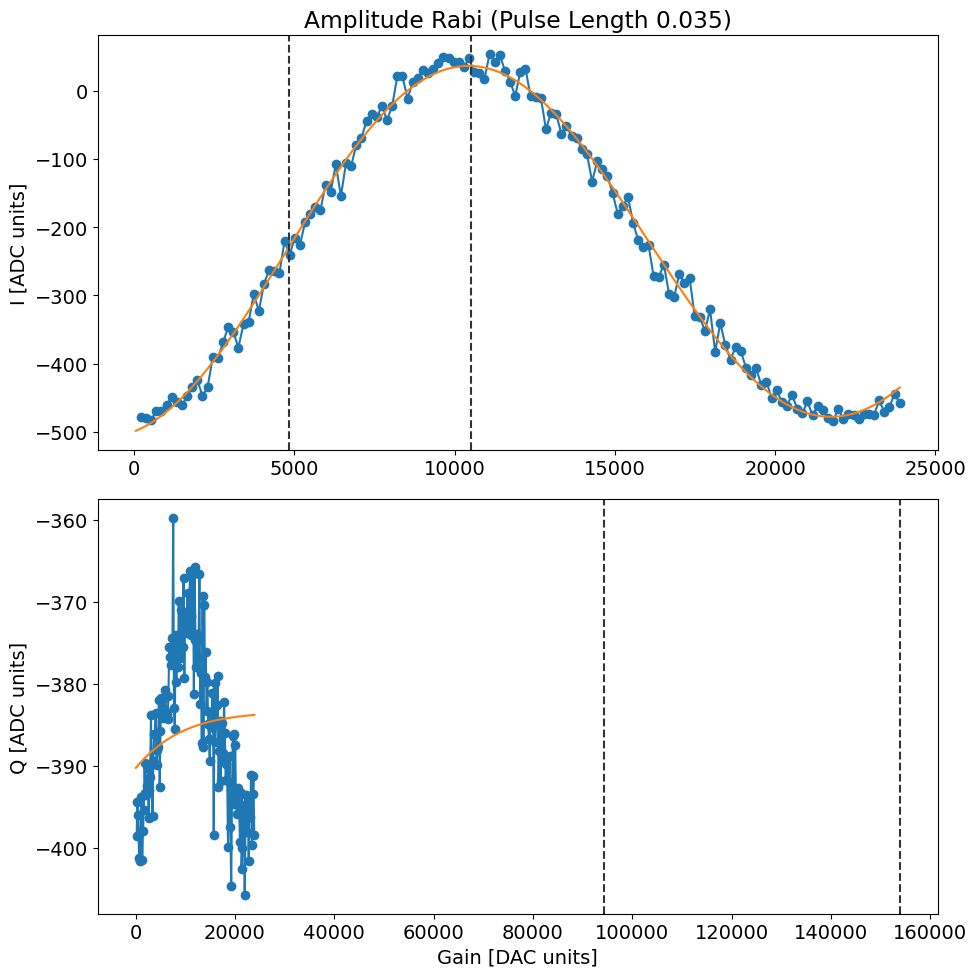

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-06_20-42-43_Amplitude_Rabi_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-06.md
Updated qubit ge pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3567.3309079751148
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00054_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3567.3309079751148
Fit frequency from I [MHz]: 0.1941752711750144 +/- 0.00023161606278203088
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.3367327039396
 	3567.7250832462896
T2 Ramsey from fit I [us]: 77.6995966538648
Fit frequency from Q [MHz]: 0.19412355924091232 +/- 0.0006840758280601967
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.336784415874
 	3567.725031534356
T2 Ramsey from fit Q [us]: 77.92228547539992


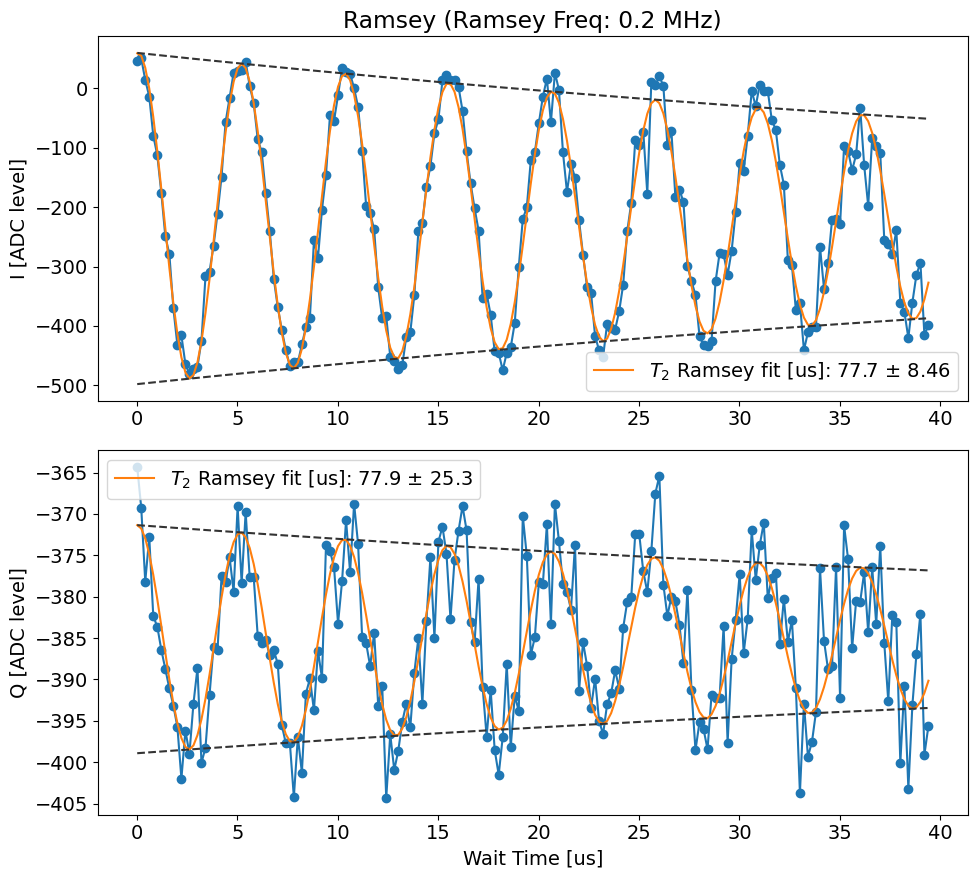

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-06_20-43-04_T2_ge_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-06.md
Updated qubit ge frequency to: 3567.3367327039396
T2 Ramsey done!


In [44]:
amprabi = None
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)
    amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
    amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
    update_amplitude_rabi(amprabi, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [45]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [46]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [47]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 10,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


In [48]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [49]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_ef_spectroscopy.PulseProbeEFSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 1,
        'gain': 300,
        # 'pulse_type': 'gaussian',
        'qubit_f': False,
        'qubit': 0,
        'cavity_drive': False,
        'wait_qubit': False,}



    qspec.cfg.device.readout.relax_delay = [500] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

In [50]:
# expts_to_run['pulse_probe_ef'] = True

  0%|          | 0/100000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00006_PulseProbeEFSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3423.9865371331953, HWHM -0.37279542637482344
Found peak in I at [MHz] 3423.985960937841, HWHM 0.36329998200115665
Found peak in Q at [MHz] 3423.9924862949247, HWHM -0.36426580194735697


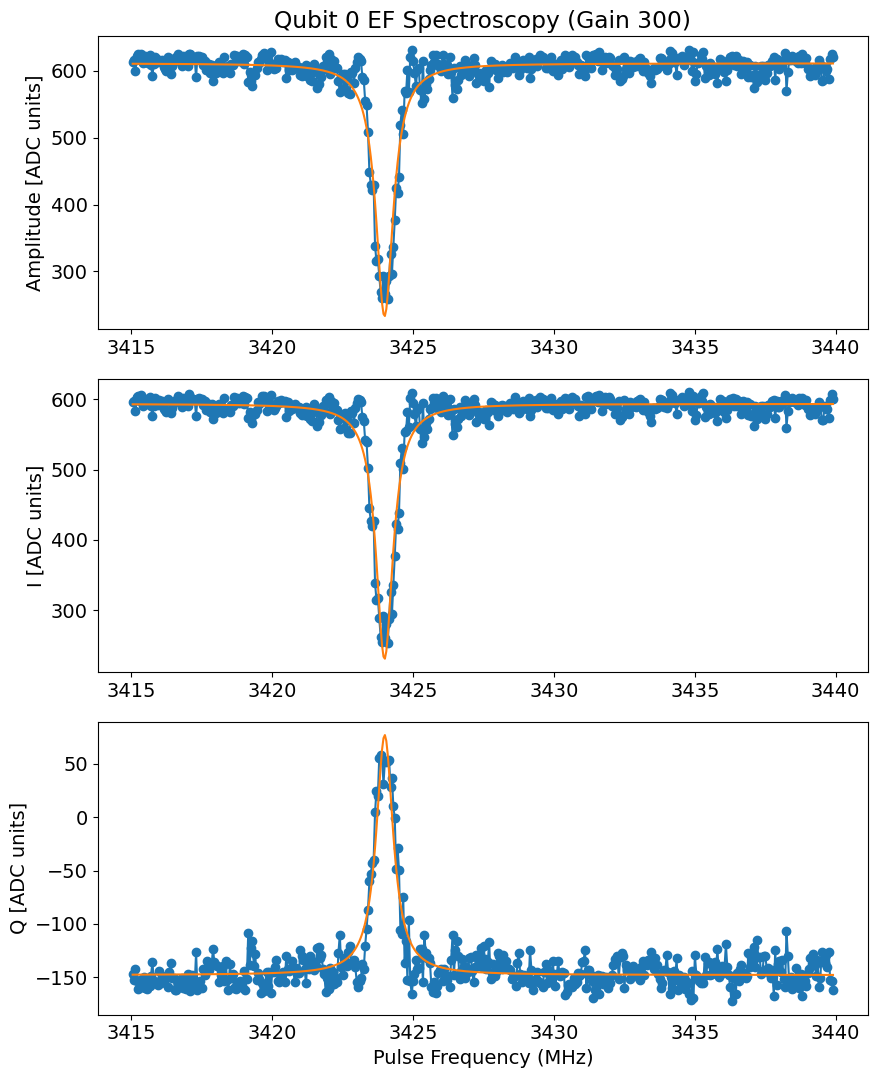

In [51]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [52]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

Updated qubit frequency!
Pulse probe spectroscopy done!


### T2 Ramsey

In [26]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path, ef_init = True, pre_sweep_pulse = None, post_sweep_pulse = None, step_size = 0.2, 
                    active_reset = False, relax_delay = 2500):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=pre_sweep_pulse, 
                            post_sweep_pulse=post_sweep_pulse, step_size=step_size, if_ef=True, ef_init=ef_init,
                            active_reset=active_reset, relax_delay=relax_delay)
    


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3567.340096037547
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3423.990931159239
Fit frequency from I [MHz]: 0.2100774030690195 +/- 0.0002811097423521771
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.9808537561703
 	3424.401008562308
T2 Ramsey from fit I [us]: 26.77087431849751
Fit frequency from Q [MHz]: 0.21029797286366556 +/- 0.00026387413682715333
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.9806331863756
 	3424.401229132103
T2 Ramsey from fit Q [us]: 27.704953055102887


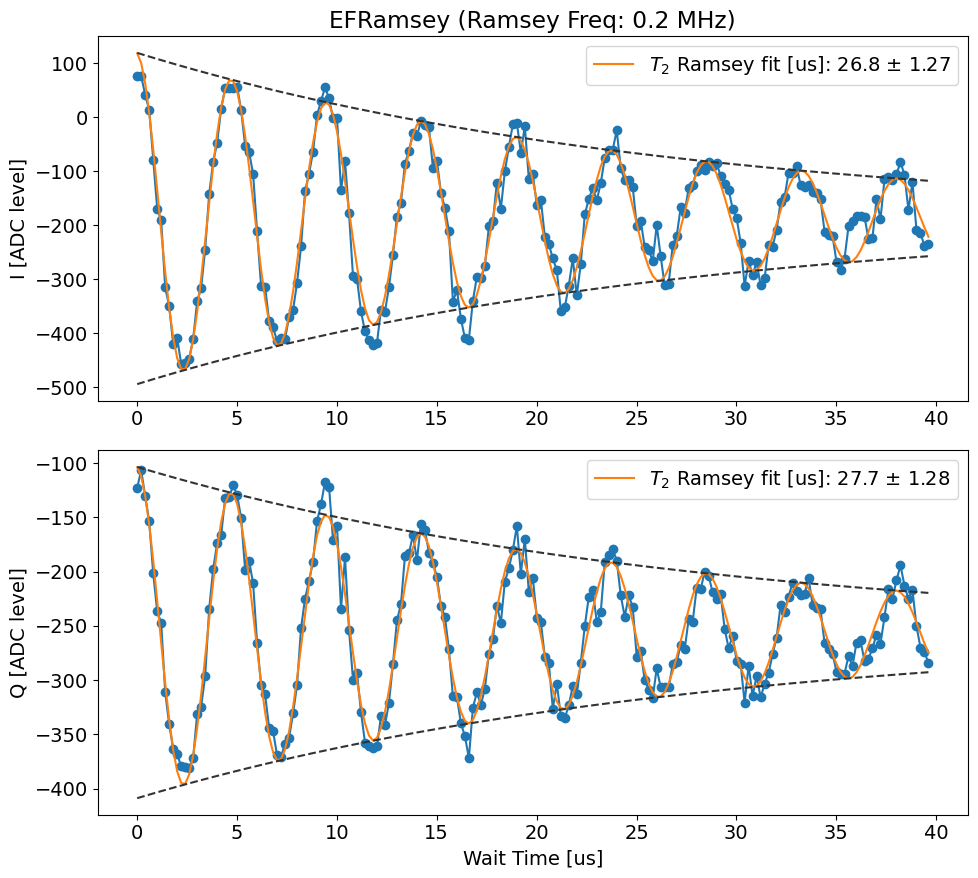

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_13-41-43_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
T2 Ramsey done!


In [29]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    # update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [31]:
# t2ramsey_ef.analyze(fitparams=[100, 10, None, 20, None, None])
# t2ramsey_ef.display(title_str='T2_ef')
update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)

Updated qubit ef frequency to: 3423.9707763531014


In [56]:
# config_thisrun.device.qubit.f_ef[0] =3424.0107360203015

In [57]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [58]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



  0%|          | 0/30200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00019_AmplitudeRabiExperiment.h5
Attempted to init fitparam 4 to -228.09657200577203, which is out of bounds 118.37770943346835 to 613.366416387541. Instead init to 365.87206291050467
Pi gain from avgi data [dac units]: 8970
	Pi/2 gain from avgi data [dac units]: 4218
Pi gain from avgq data [dac units]: 107679
	Pi/2 gain from avgq data [dac units]: 48103


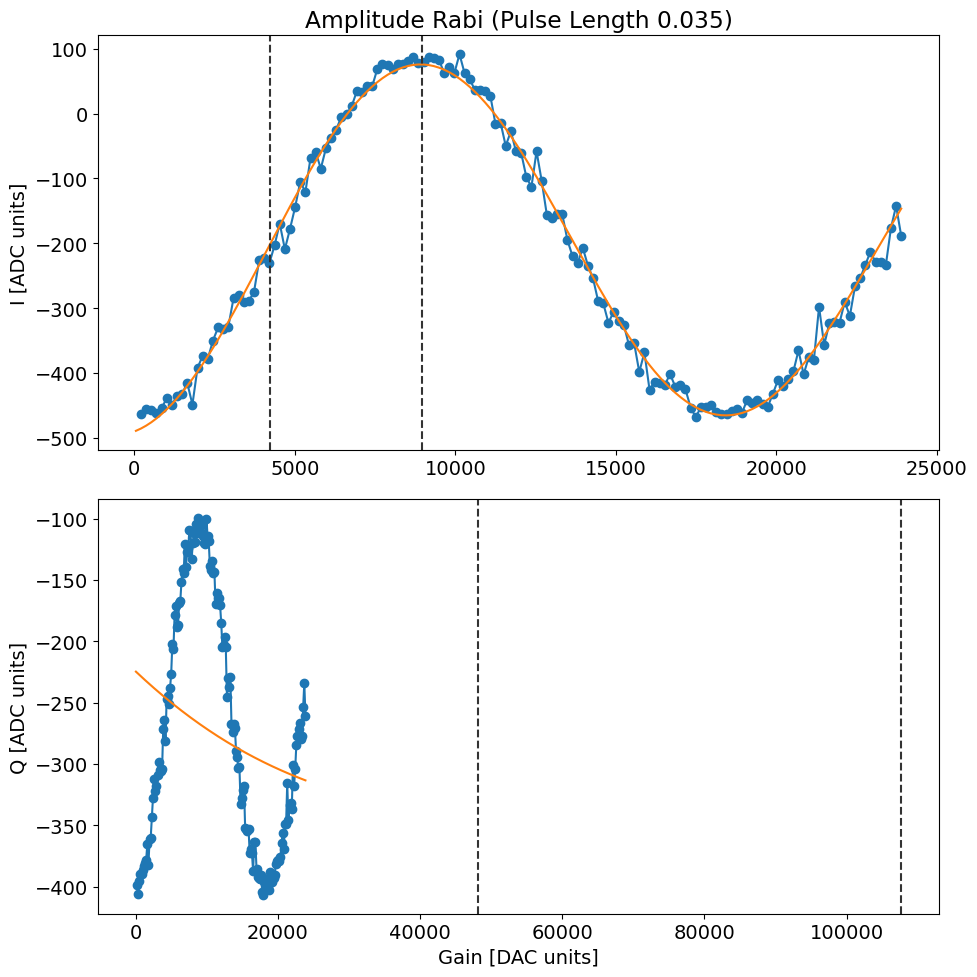

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-06_20-47-14_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-06.md
Updated qubit ef pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3567.3367327039396
fef is  3423.979519694744


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00056_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3423.979519694744
Fit frequency from I [MHz]: 0.20139840730581246 +/- 0.00026204686884492726
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.978121287438
 	3424.3809181020497
T2 Ramsey from fit I [us]: 27.763812813101637
Fit frequency from Q [MHz]: 0.20122386241539153 +/- 0.00027095203521553457
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.9782958323285
 	3424.3807435571593
T2 Ramsey from fit Q [us]: 27.692134269512714


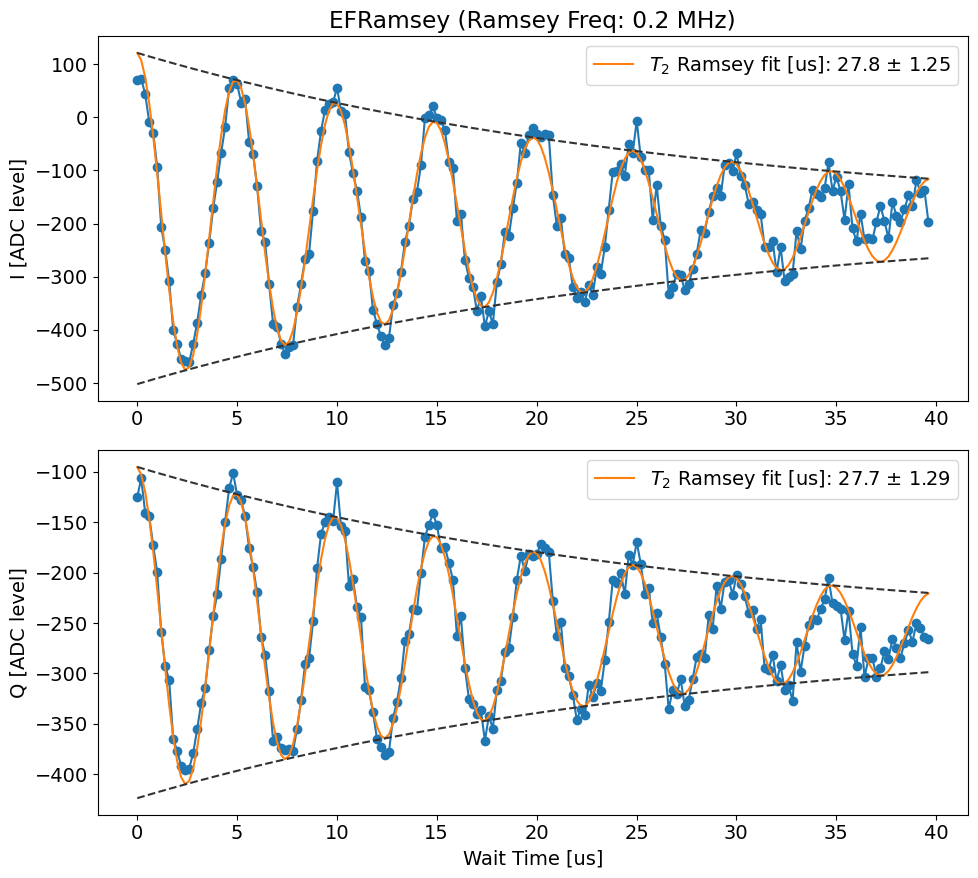

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-06_20-49-02_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-06.md
Updated qubit ef frequency to: 3423.978121287438
T2 Ramsey done!


In [59]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None])
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [60]:
# amprabi_ef.analyze(title_str = 'Amplitude Rabi_ef', save_fig=False, fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, 90, None, None, None])
# amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=False)
# Magic Params: [np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None]

In [61]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# # After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

In [62]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

### T1

In [63]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


In [64]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [40]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 5,  # resonator frequency to be mixed up [MHz]
        'step': 0.02,  # min step ~1 MHz
        'expts': 500,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 5000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    print('Updated man f0g1 freq to :', ds_thisrun.get_freq('M1'))


In [41]:
# expts_to_run['pulse_probe_f0g1'] = True

Running pulse probe f0g1 for mode 1


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00000_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2006.1724446825522, HWHM 0.43013213396897054
Found peak in I at [MHz] 2006.191463549513, HWHM -0.4365804954684999
Found peak in Q at [MHz] 2006.1446289929315, HWHM -0.46372236728726296


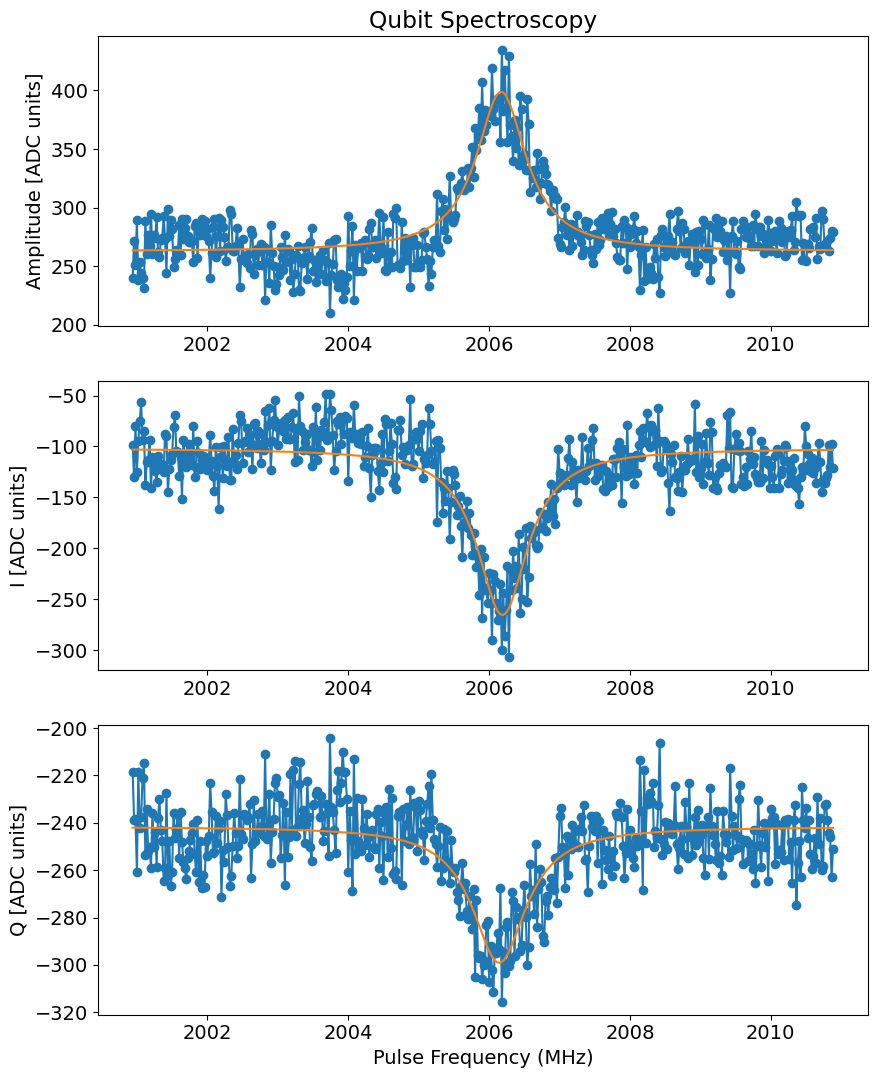

Updated man f0g1 freq to : 2006.191463549513


In [42]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        

## Find Frequency (Chevron)


In [68]:
%matplotlib inline

In [43]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path,
                                      exp_param_file=exp_param_file, config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 2,
        'step': 0.05,
        'qubits': [0],
        'expts': 101,
        'reps': 100,
        'rounds': 1,
        'gain': 15000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': [],
        'err_amp_reps' : 0, # Number of error amp rounds
    } # actually this doesn't do anything, edit experiment.yml
    
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],
        config = config_thisrun
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True,  title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis


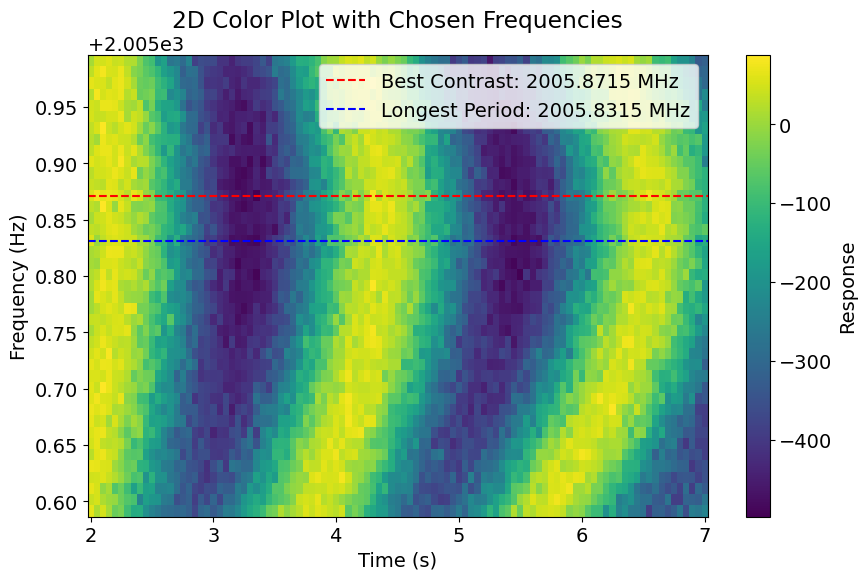

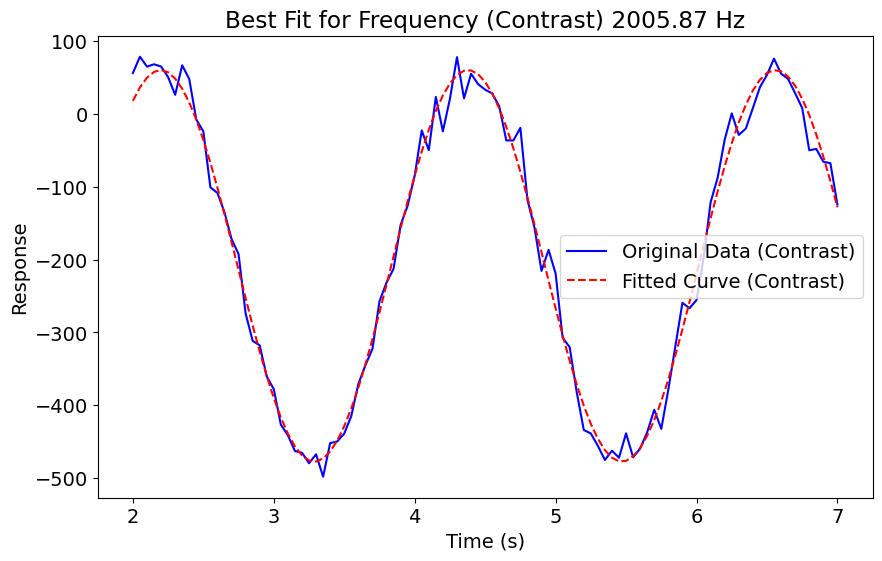

File saved at : H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00001_length_rabi_f0g1_sweep.h5
supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_14-39-33_M1_2025-07-08_14-39-33.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md


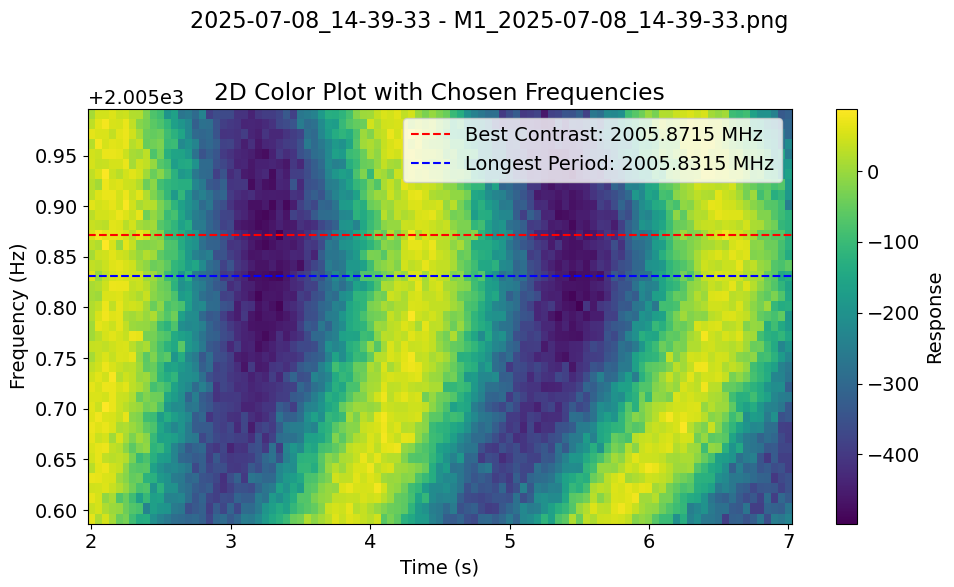

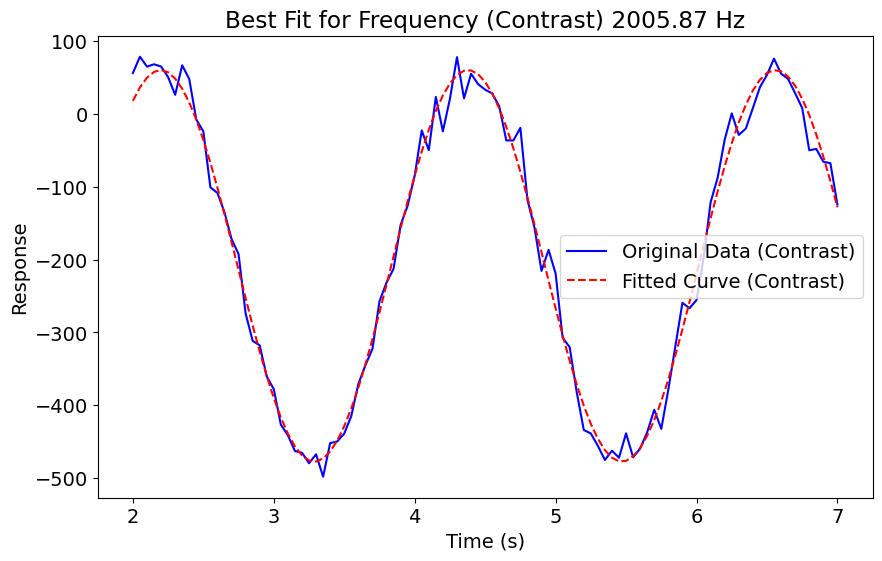

Updated the frequency to: 2005.871463549513


In [44]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 2
        freq_step = 0.2
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.01
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [45]:
ds_thisrun.update_freq('M1', 2005.85)

## Length Rabi f0g1 (Update time)

In [57]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=soc.cycles2us(3),  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=150,
        reps=100,
        rounds=1,
        # rep_start=0, # 0 means just 1 pi pulse, no error amp
        # rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ge_after=True,
        # pi_ef_after=True,
        normalize=False,
        active_reset=True,
        man_reset=True,
        stor_reset=True,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[],
        err_amp_reps = 0, # Number of error amp rounds
    )

    length_rabi.cfg.device.readout.relax_delay = [20]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')


    return length_rabi_analysis


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""

    # Update dataset
    pi_length = length_rabi.results['pi_length']
    pi2_length = length_rabi.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



In [58]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)
        

Running length rabi for mode 1


AttributeError: module 'experiments' has no attribute 'single_qubit'

In [74]:
# len_rabis_mans[0].active_reset = True
# len_rabis_mans[0].analyze()
# len_rabis_mans[0].display(title_str='Length Rabi General F0g1')

In [75]:
# idata = len_rabis_mans[0].data['idata']
# idata = idata.reshape((len(idata.flatten())//4,4))

# qdata = len_rabis_mans[0].data['qdata']
# qdata = qdata.reshape((len(qdata.flatten())//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [76]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*50,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [77]:
# length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

In [78]:
# lines = []
# ypts = []
# for prefix_num in range(43,63):
#     fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
#     lines.append(temp_data['avgi'])
    
# xpts = temp_data['xpts']
# ypts = np.array(ypts)
# lines = np.array(lines)

# import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# # add vertical line at dsthisrun.get_pi('M1')
# plt.axvline(x=ds_thisrun.get_pi('M1'), color='r', linestyle='--', label='Old calib Pi Pulse Length')

# # add vertical line where the new calib pi pulse length is
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.axvline(x=xpts[xmax], color='g', linestyle='--', label='New calib Pi Pulse Length')
# # in legend mention the difference between the two
# diff = xpts[xmax] - ds_thisrun.get_pi('M1')
# plt.legend(title=f'ΔPi = {diff:.5f} us')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Length Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.show()


In [79]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [80]:
def amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-50*50,  # Pulse start length [dac unit]
        step=50,  # Pulse step length [dac unit]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0,
        rep_end=19,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        amp_rabi = meas.single_qubit.amplitude_rabi_f0g1_general.AmplitudeRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='AmplitudeRabiGeneralF0g1Experiment', config_file=config_path
        )

        amp_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        amp_rabi.cfg.expt = expt_cfg

        amp_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        amp_rabi.go(analyze=False, display=False, progress=False, save=True)
    return amp_rabi

In [81]:
# amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    # 

In [82]:
# lines = []
# ypts = []
# for prefix_num in range(15,35):
#     fname = f'{prefix_num:05d}_AmplitudeRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     lines.append(temp_data['avgi'])
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
# xpts = temp_data['xpts']

# lines = np.array(lines)
# ypts = np.array(ypts)

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# plt.axvline(x=ds_thisrun.get_gain('M1'), color='r', linestyle='--', label='Old calib Gain')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Amplitude Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.legend()
# plt.show()

In [83]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')

## Chi between qubit and Manipulate 

### ge

In [84]:
from MM_dual_rail_base import MM_dual_rail_base
import numpy as np

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
# do_t2_ramsey_ge is already defined in previous cells and can be used directly

# Add active_reset, relax_delay, expts as arguments and pass them to do_t2_ramsey_ge
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1, active_reset=False, relax_delay=2500, expts=100):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(
            config_thisrun, expt_path, config_path,
            pre_sweep_pulse=None, post_sweep_pulse=None,
            step_size=0.1,
            active_reset=active_reset,
            relax_delay=relax_delay,
            expts=expts
        )
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(
        config_thisrun, expt_path, config_path,
        pre_sweep_pulse=prepulse, post_sweep_pulse=None,
        step_size=0.1,
        active_reset=active_reset,
        relax_delay=relax_delay,
        expts=expts
    )

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse


def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


In [85]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
# Run the chi experiments/__pycache__/
if expts_to_run['chi_ge']:
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

fge is  3567.3367327039396
fef is  3423.978121287438


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00057_RamseyExperiment.h5


TypeError: prep_man_photon() missing 1 required positional argument: 'photon_no'

In [ ]:
# config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

### ef

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


fge is  3567.3506008394015
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00045_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3423.990931159239
Fit frequency from I [MHz]: 0.2000749964652766 +/- 0.0001832791236603276
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.990856162774
 	3424.3910061557044
T2 Ramsey from fit I [us]: 44.36398687428788
Fit frequency from Q [MHz]: 0.19996095977120268 +/- 0.00018364781101622092
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.990970199468
 	3424.3908921190105
T2 Ramsey from fit Q [us]: 44.806576487499456


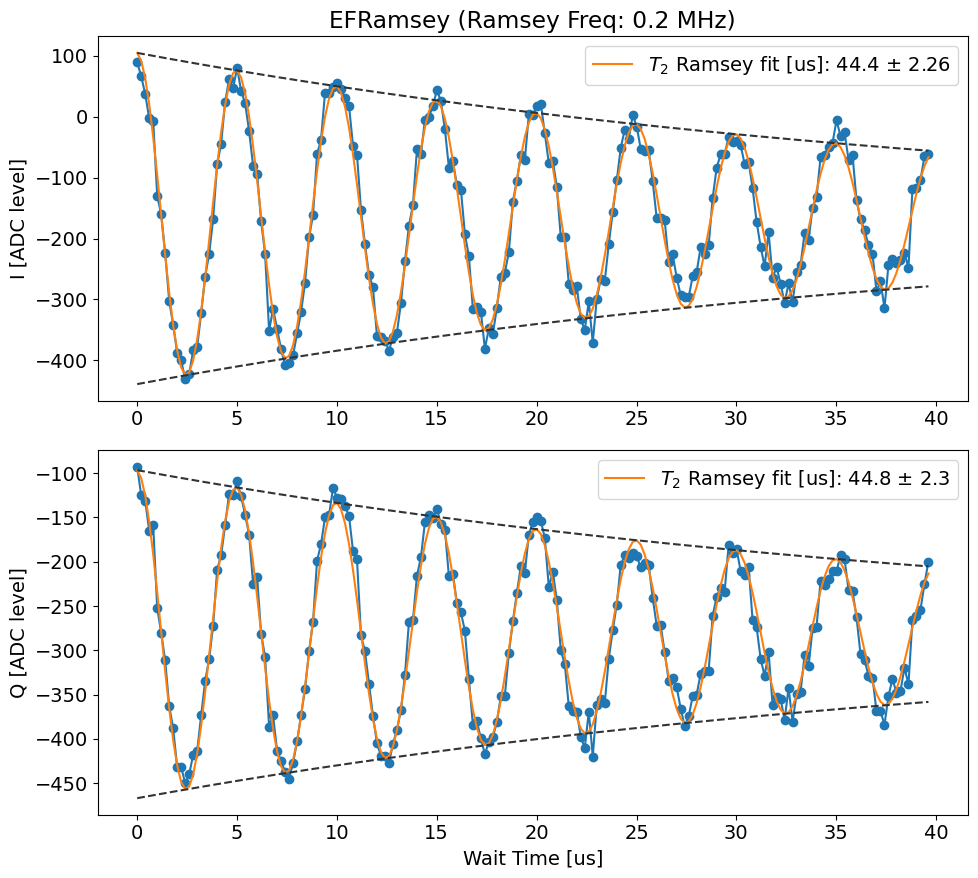

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-29_22-20-25_T2_ef_standard_for_chief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-29.md
fge is  3567.0780090918365
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00046_RamseyExperiment.h5
fge is  3567.0780090918365
fef is  3423.990931159239


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00047_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -128.290117830429, which is out of bounds -402.8740746433054 to -300.31745207173776. Instead init to -351.5957633575216
Current pi pulse frequency: 3567.0780090918365
Fit frequency from I [MHz]: 0.2189791763641886 +/- 0.00042142833734914195
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.0590299154724
 	3567.4969882682008
T2 Ramsey from fit I [us]: 88.56222514237544
Fit frequency from Q [MHz]: 0.21897755962603305 +/- 0.0012404870278130994
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.0590315322106
 	3567.4969866514625
T2 Ramsey from fit Q [us]: 17.358707097872163


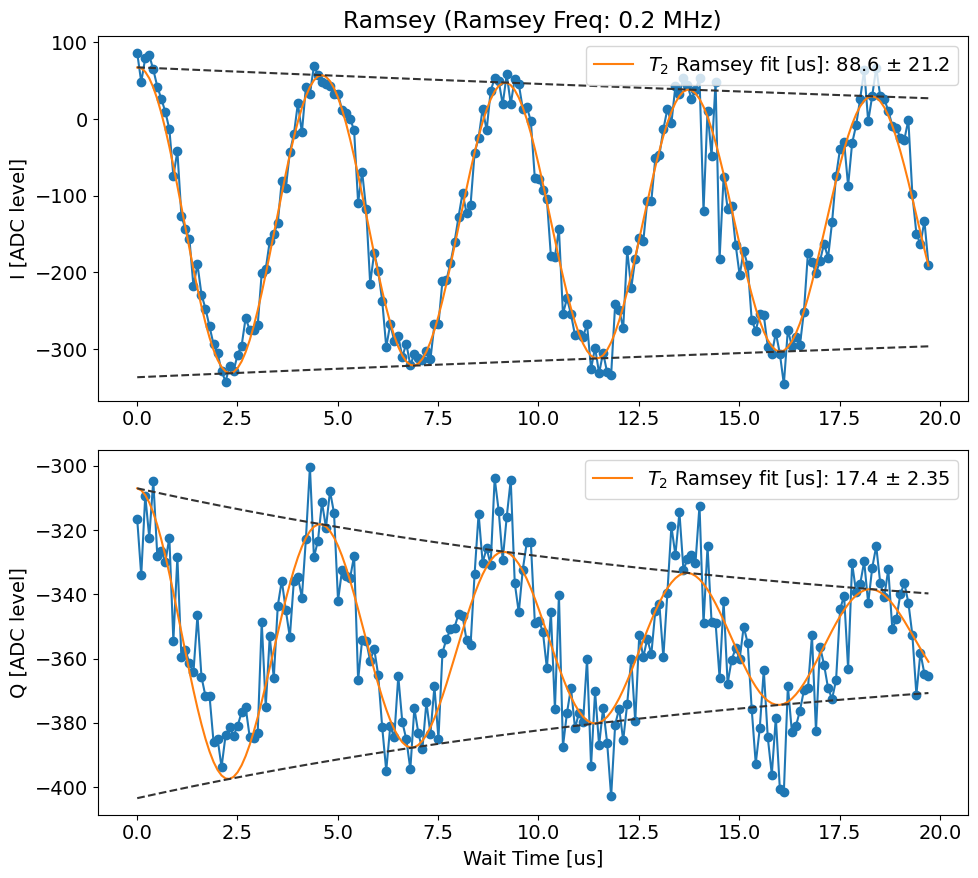

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-29_22-22-34_T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-29.md
No echoes in the data
Current pi pulse frequency: 3423.990931159239
Fit frequency from I [MHz]: 0.44487831812918194 +/- 0.0002690747913425308
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.7460528411098
 	3424.635809477368
T2 Ramsey from fit I [us]: 49.79303234611611
Fit frequency from Q [MHz]: 0.44466263600396744 +/- 0.0002779030583480039
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.7462685232354
 	3424.635593795243
T2 Ramsey from fit Q [us]: 51.7626664777665


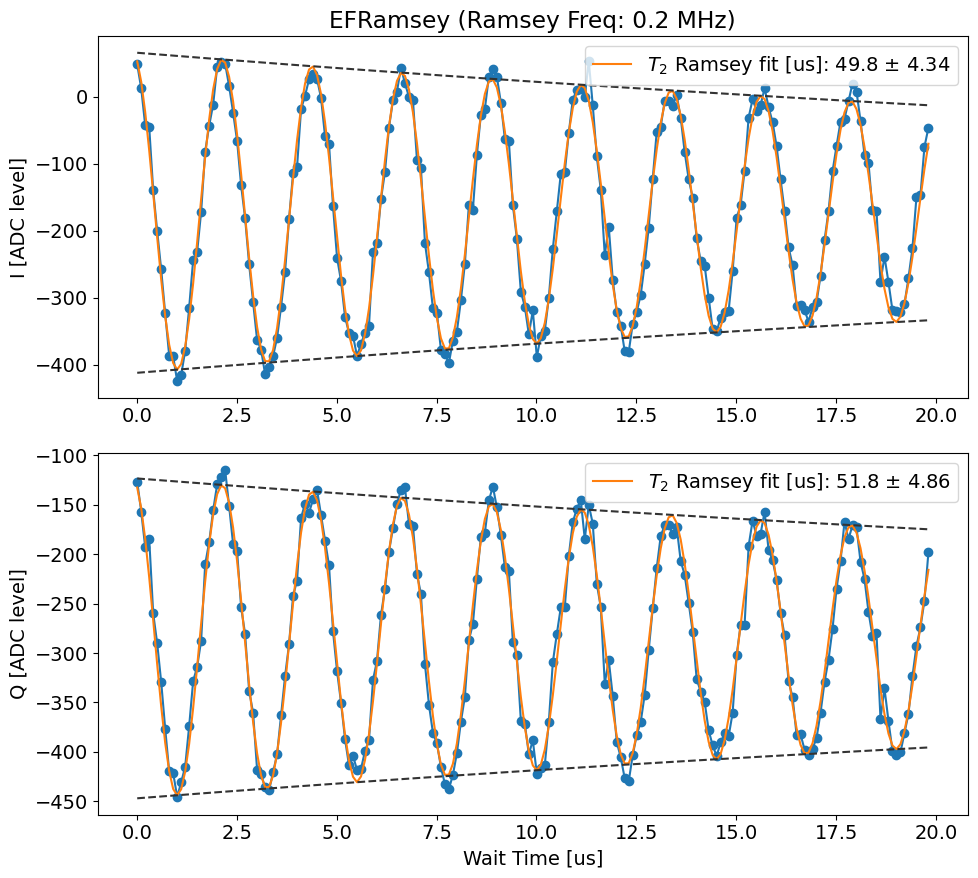

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-29_22-22-34_T2_ef_for_chief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-29.md
Chi: -0.24480332166390534


In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


In [ ]:
# update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)

In [ ]:
# t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ge_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
# t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ef_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
# t2ge_ramsey_forchief.analyze()
# t2ge_ramsey_forchief.display(title_str='T2_ge_ramsey_forchief')

## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [ ]:


def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



In [ ]:
# t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2
06/19/2025: The code below should use man ramsey directly instead of user defined; user defined is for ramsey where you directly displace manipulate mode  - Eesh

In [ ]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.2,
        expts=200,
        ramsey_freq=1.2,
        reps=100,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[False, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_mode_no=man_mode_no ,
        storage_ramsey=[False, 2, True],
        man_ramsey=[True, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[False, 0],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

phase update channel: [0]
Inside cavity ramsey code
[['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]]
[[2005.922592734436]
 [15000]
 [1.0979275177896148]
 [0]
 [0]
 ['flat_top']
 [0.005]]
[0]
phase step deg: 86.4
phase step logic: +
inide t2 cavity acquire
200


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00003_CavityRamseyExperiment.h5


Attempted to init fitparam 1 to 0.6030150753768844, which is out of bounds 0.0025252525252525255 to 0.3787878787878788. Instead init to 0.19065656565656566
Current pi pulse frequency: 3567.3506008394015
Fit frequency from I [MHz]: 0.30305045311317497 +/- 0.00015855160529122653
Suggested new pi pulse frequency from fit I [MHz]:
 	3568.2475503862884
 	3568.8536512925148
T2 Ramsey from fit I [us]: 76.17679911961007
Fit frequency from Q [MHz]: 0.3031073321864605 +/- 0.00034644207536413315
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3568.247493507215
 	3568.853708171588
T2 Ramsey from fit Q [us]: 94.24192310659065


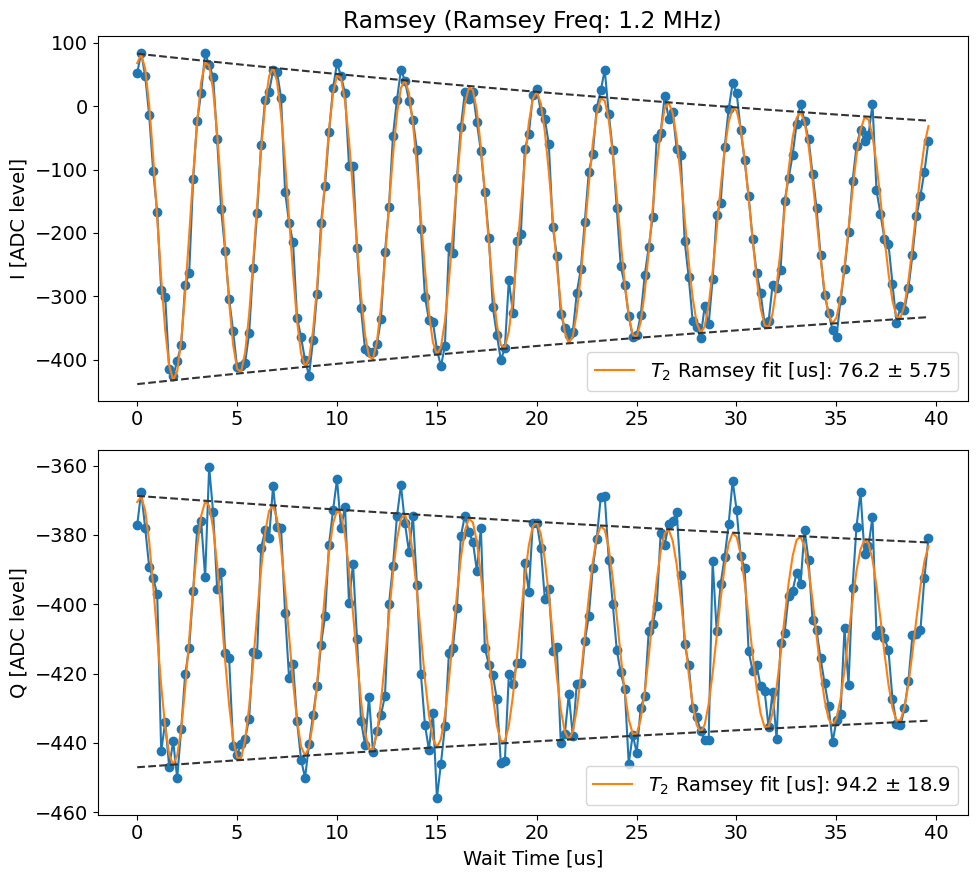

In [ ]:
cavity_ramsey.analyze()
cavity_ramsey.display()

# Storage

## Stor Spectroscopy

In [24]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1, 
                         use_flux_low=False):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)
    if use_flux_low:
        ch = 'low'
    print('channel:', ch)

    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


Running flux spectroscopy f0g1 for mode 1
channel: low


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00000_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 347.7469807352015, HWHM 1.4049497883935624
Found peak in I at [MHz] 347.8021350688022, HWHM 1.521303174743437
Found peak in Q at [MHz] 363.39434739378856, HWHM 2.955000000000001


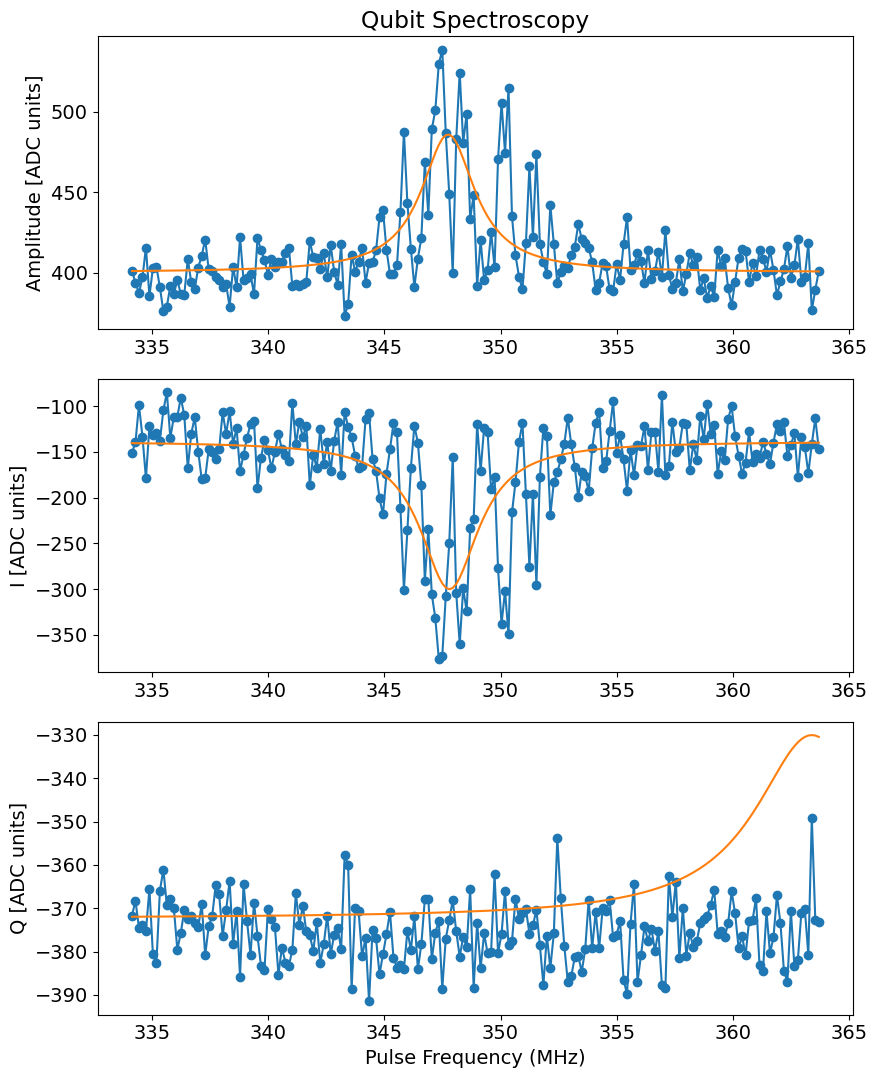

Updated frequency for M1-S1: 347.8021350688022
Running flux spectroscopy f0g1 for mode 2
channel: low


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00001_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 515.7615281544373, HWHM 29.495109849674403
Found peak in I at [MHz] 519.7992494879364, HWHM 2.940164296865479
Found peak in Q at [MHz] 513.0202204192906, HWHM -46.266765132691354


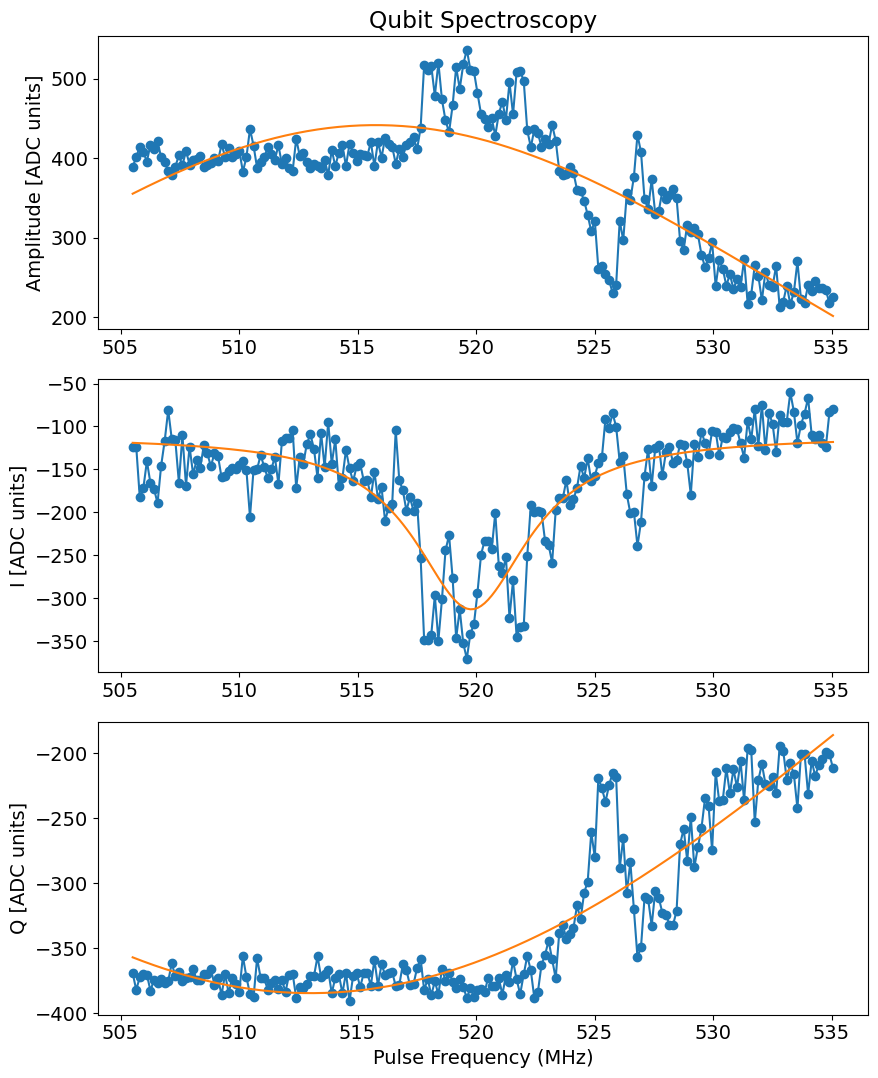

Updated frequency for M1-S2: 519.7992494879364
Running flux spectroscopy f0g1 for mode 3
channel: low


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 696.1052891644977, HWHM -0.454141180464226
Found peak in I at [MHz] 696.1105138887389, HWHM -0.44494515630833914
Found peak in Q at [MHz] 695.5721436864043, HWHM 1.1903934344165061


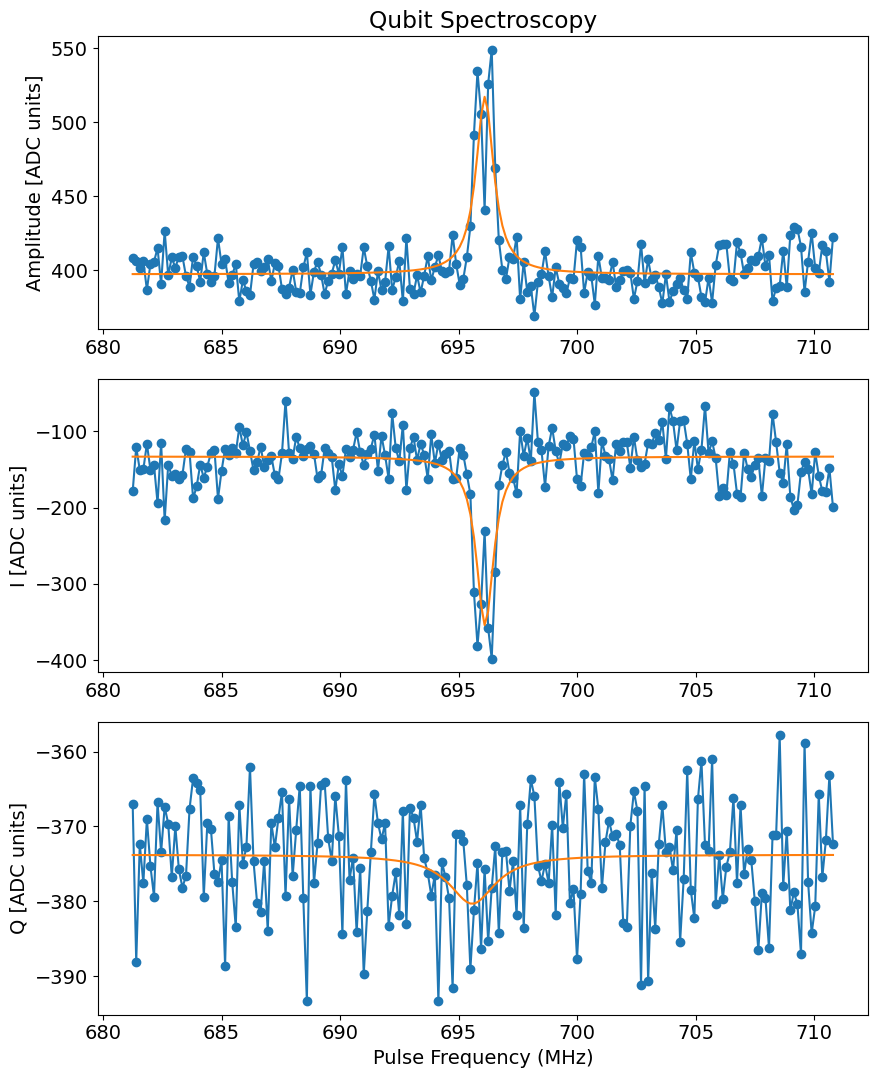

Updated frequency for M1-S3: 696.1105138887389
Running flux spectroscopy f0g1 for mode 4
channel: low


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00003_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 874.4698396493931, HWHM -0.38477833654045035
Found peak in I at [MHz] 874.4510031841337, HWHM -0.4445534453282468
Found peak in Q at [MHz] 886.9668762067706, HWHM -0.09630414112773064


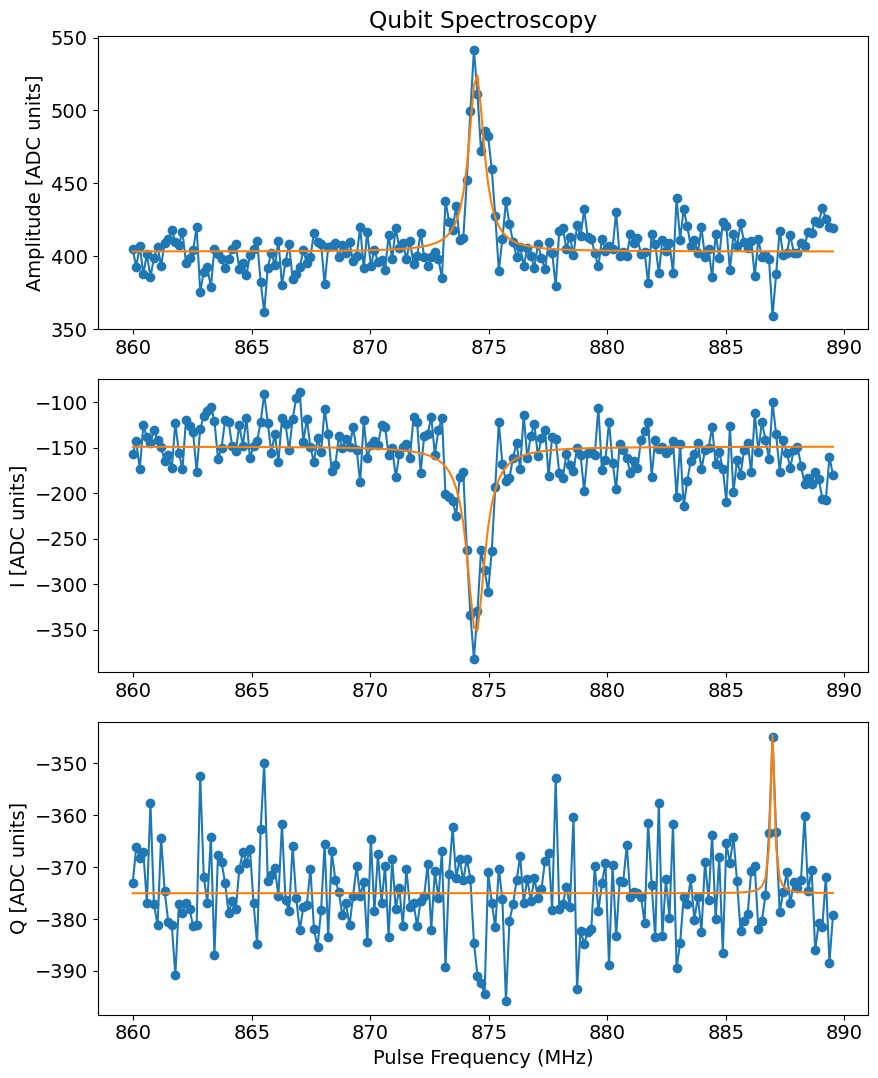

Updated frequency for M1-S4: 874.4510031841337
Running flux spectroscopy f0g1 for mode 5
channel: high


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00004_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1053.8942088083547, HWHM -0.5215609194707431
Found peak in I at [MHz] 1053.903448444773, HWHM -0.5291408085036119
Found peak in Q at [MHz] 1043.8153819812117, HWHM 0.7653088695077099


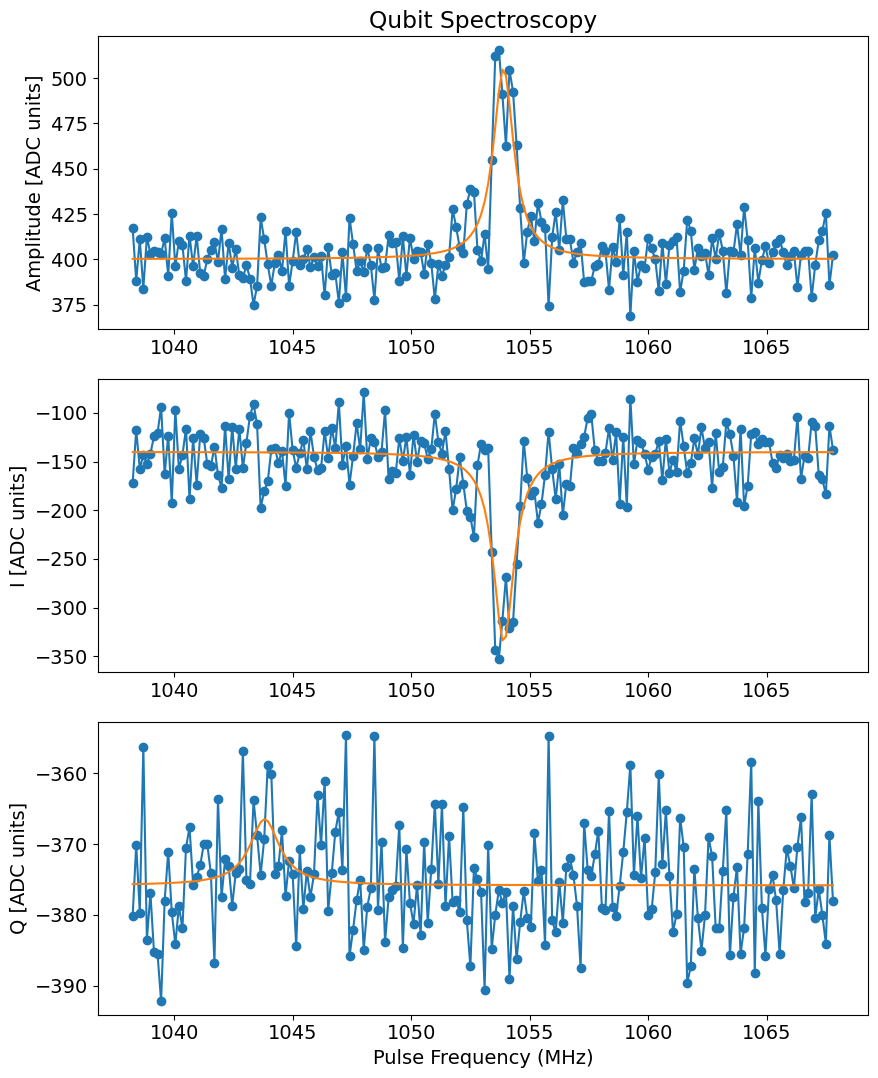

Updated frequency for M1-S5: 1053.903448444773
Running flux spectroscopy f0g1 for mode 6
channel: high


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00005_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1244.6241135187977, HWHM -0.4077445897321232
Found peak in I at [MHz] 1244.6145808156996, HWHM 0.42254956532560506
Found peak in Q at [MHz] 1233.7961714745259, HWHM 1.749590137112628


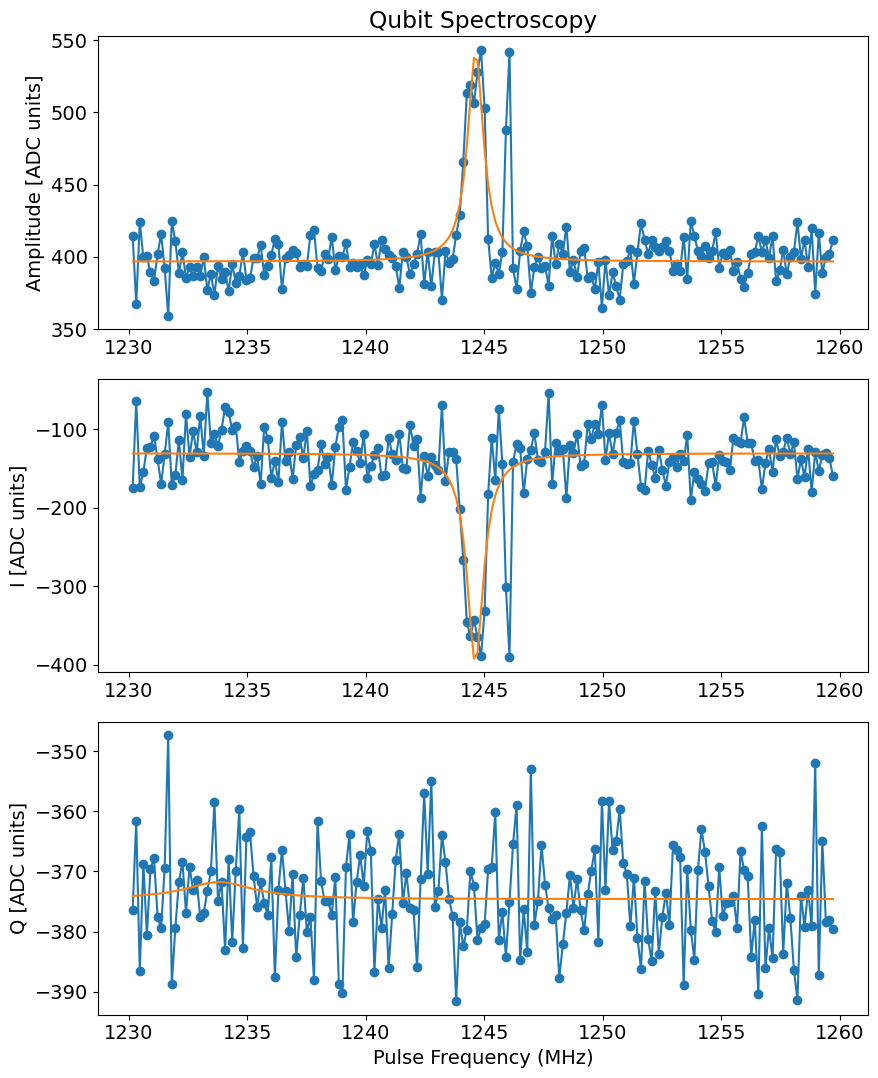

Updated frequency for M1-S6: 1244.6145808156996
Running flux spectroscopy f0g1 for mode 7
channel: high


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00006_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1422.5305355059156, HWHM 0.2823953916901327
Found peak in I at [MHz] 1422.5184365717917, HWHM 0.30236629863499076
Found peak in Q at [MHz] 1414.398860475665, HWHM -0.1369112869626642


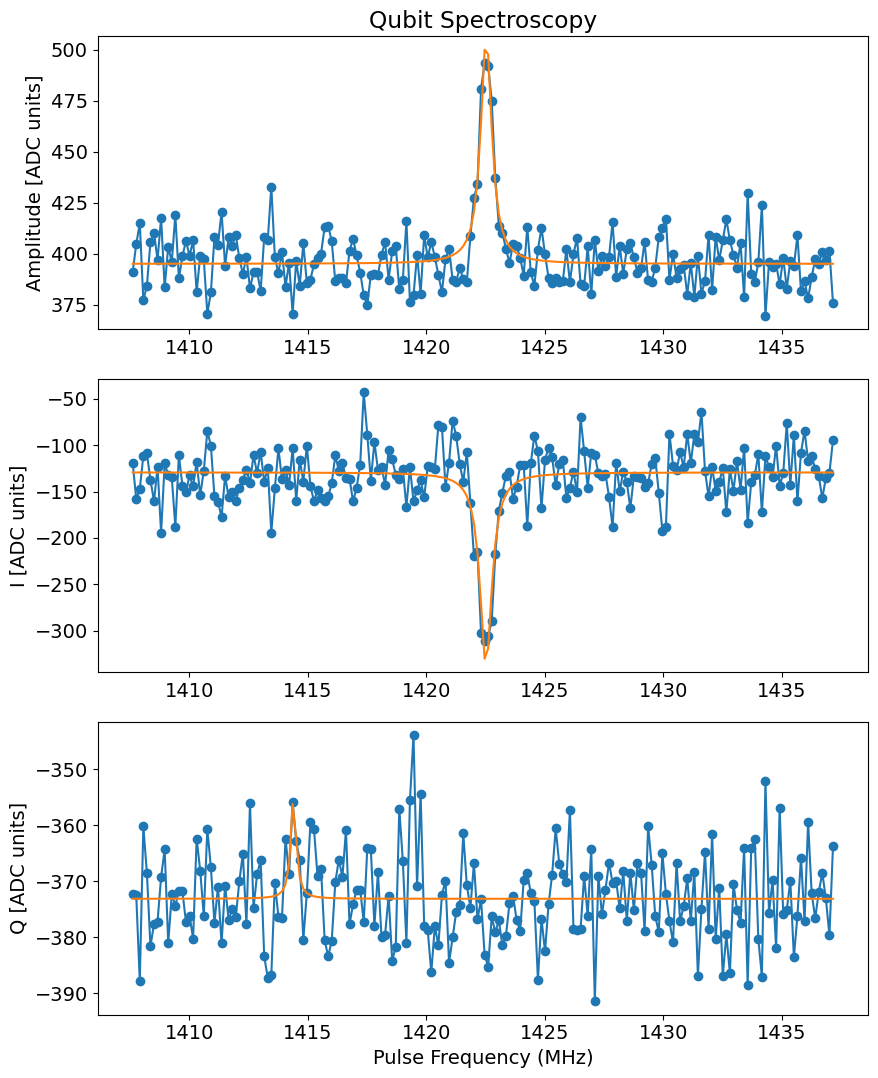

Updated frequency for M1-S7: 1422.5184365717917


In [53]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

channel: high


  0%|          | 0/200 [00:00<?, ?it/s]

generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_fre

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00034_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1244.5521891565418, HWHM -0.3218036520294371
Found peak in I at [MHz] 1244.5364279800203, HWHM -0.36445709780671953
Found peak in Q at [MHz] 1244.6290156699256, HWHM 0.40106222499893623


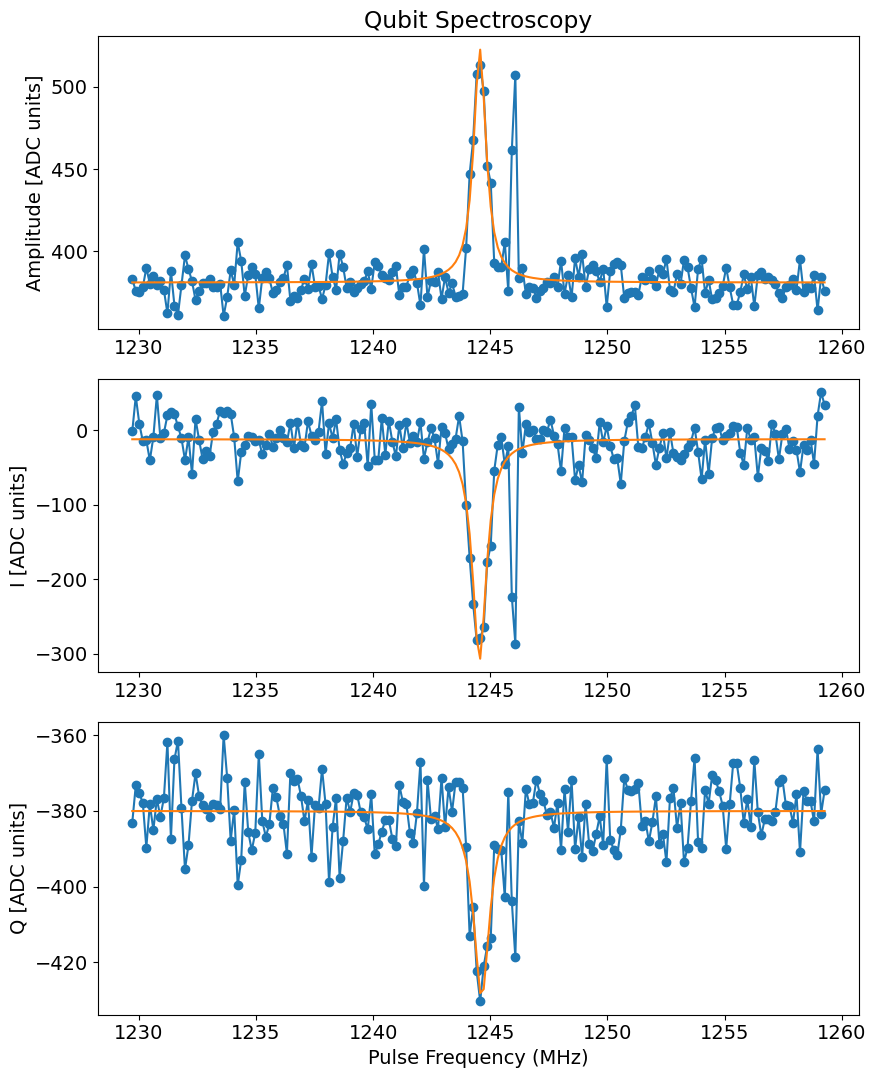

In [ ]:
# flux high 
i = 5
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1, use_flux_low = False)
analyze_and_display_stor_spectroscopy(spec)

channel: low


  0%|          | 0/200 [00:00<?, ?it/s]

generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_freq was defined
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 5 doesn't have a digital mixer, but mixer_fre

Saving H:\Shared drives\SLab\Multimode\experiment\250625_bosonic\data\00035_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1244.560853761975, HWHM -0.3302559929248374
Found peak in I at [MHz] 1244.5633732081976, HWHM 0.38966698434926006
Found peak in Q at [MHz] 1244.5097584205537, HWHM 0.42351382993318987


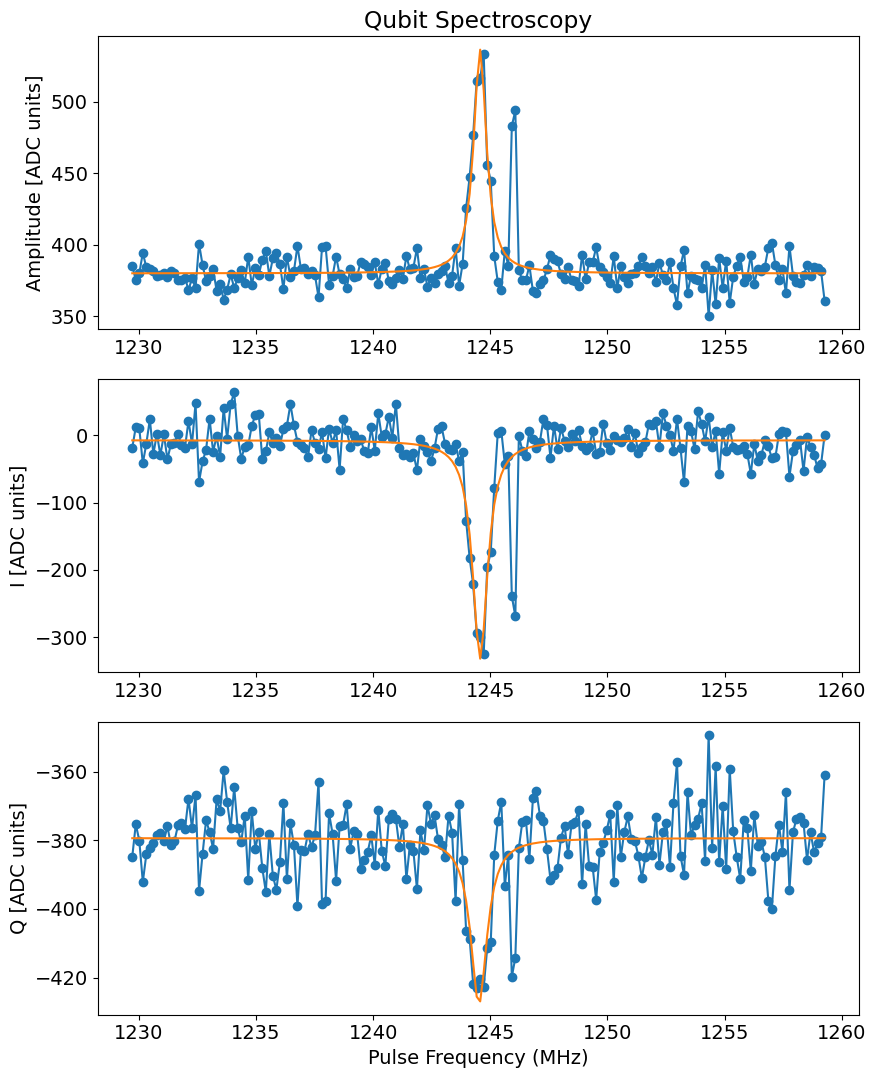

In [ ]:
# flux low
i = 5
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1, use_flux_low = True)
analyze_and_display_stor_spectroscopy(spec)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


Frequency for M1-S1: 348.6943473937892
Frequency for M1-S2: 520.021274401907
Frequency for M1-S3: 693.2346768196082
Frequency for M1-S4: 874.5253787484354
Frequency for M1-S5: 1053.8875732177962
Frequency for M1-S6: 1244.566393007914
Frequency for M1-S7: 1422.4517180715495


### Man-dump

In [ ]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, dump_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    flux_spec.cfg.expt = dict(
        start=freq - 5,  # Start RF frequency [MHz]
        step=0.05,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,4000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit_avgi'][2]}")


In [ ]:
# spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, dump_no=1)
# analyze_and_display_stor_spectroscopy(spec)

In [ ]:
# update_dump_spectroscopy(spec, ds_thisrun, man_mode_no = 1, dump_no = 1)
# ds_thisrun.update_gain('M1-D1', 4000)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))


Frequency for M1-S1: 348.6943473937892
Frequency for M1-S2: 520.021274401907
Frequency for M1-S3: 693.2346768196082
Frequency for M1-S4: 874.5253787484354
Frequency for M1-S5: 1053.8875732177962
Frequency for M1-S6: 1244.566393007914
Frequency for M1-S7: 1422.4517180715495


## Find Frequency (Chevron)

In [27]:
def do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
                              man_mode_no = 1, stor_mode_no = 1, start_time = 0.007, use_flux_low=False):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file,
                                     config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    if use_flux_low:
        ch = 'low'
        gain = int(1.0 * gain)  # Increase gain for since flux low will attenuate for freq>1000 mhz
    print('channel:', ch)
    print('gain:', gain)

    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=0.3,  # Pulse step length [us]
        qubits=[0],
        expts=30,
        reps=90,
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],config = config_thisrun,
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no),chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis

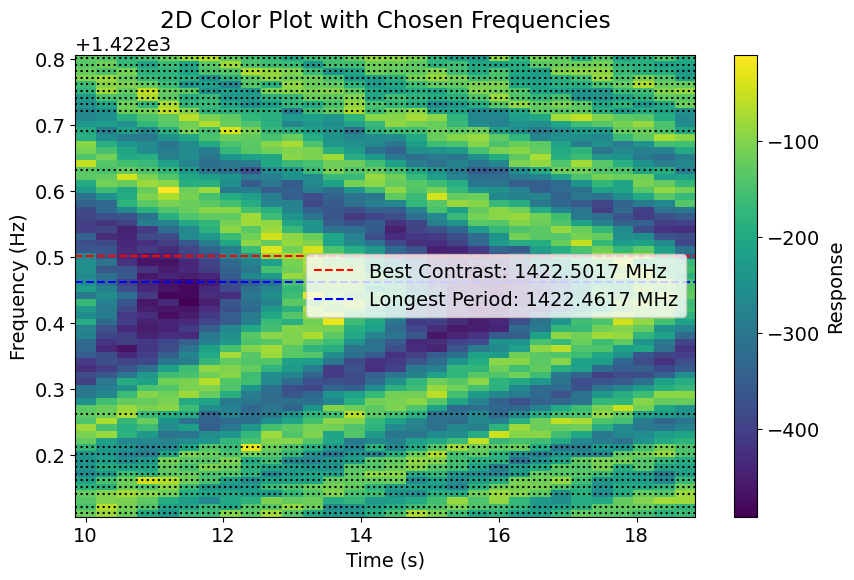

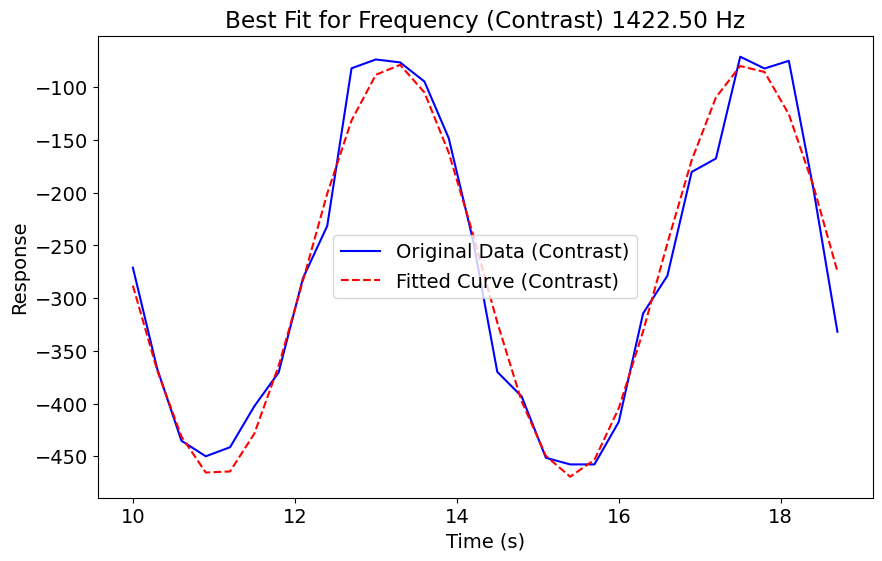

File saved at: H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00013_sideband_general_sweep.h5
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as 

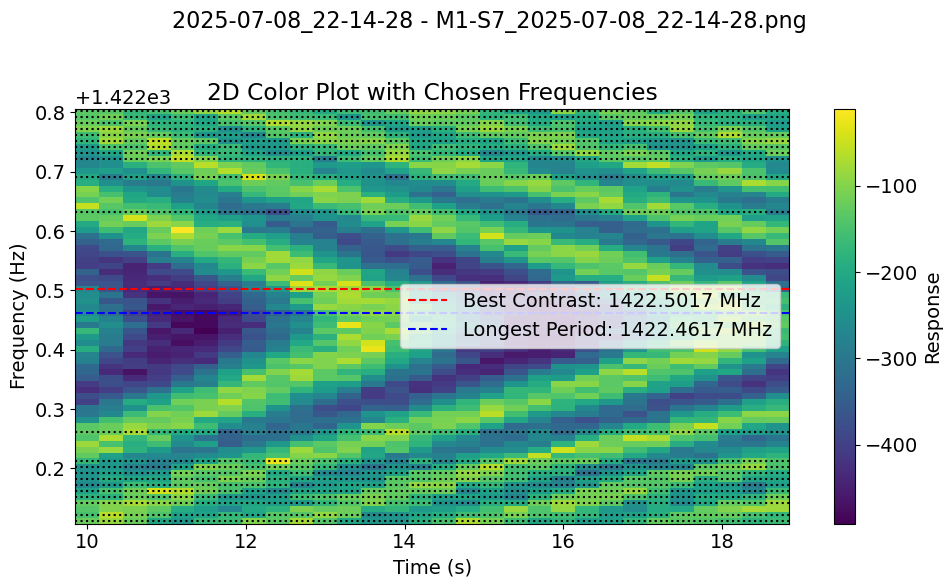

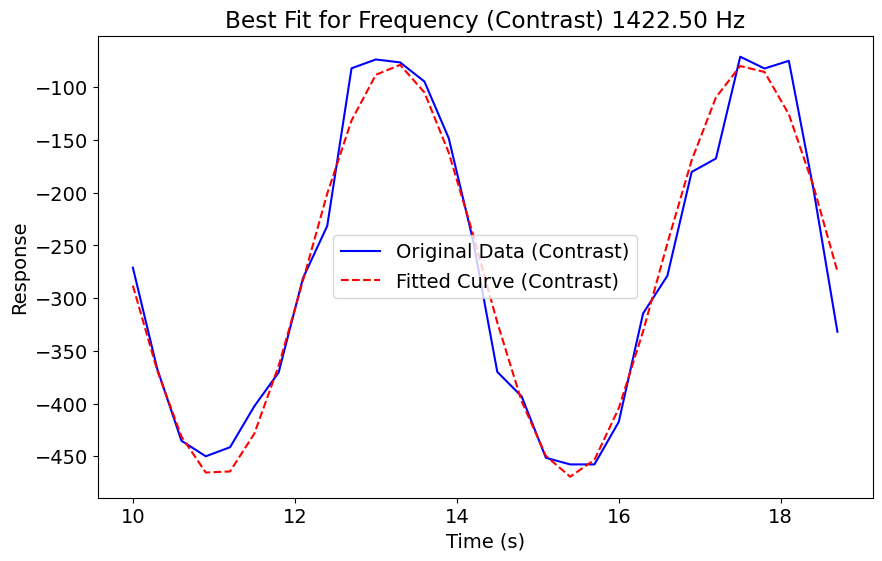

Updated the frequency to: 1422.5017180715504


In [28]:
sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])

for i in range(len(expts_to_run['stor_modes'])):
# for i in [5]:
    if expts_to_run['sideband_freq_sweep']:
        print(f'Running coarse sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 3
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 3
        freq_step = 0.2
        sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, man_mode_no=1, stor_mode_no=i + 1)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

        print(f'Running fine sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.35
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.35
        freq_step = 0.01
        sideband_chevrons_fine[i] = do_sideband_general_sweep(
            config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
            man_mode_no=1, stor_mode_no=i + 1, start_time=10, use_flux_low=True)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

In [29]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_thisrun.get_freq('M1-S' + str(i+1)))

Frequency for M1-S1: 348.95434739378794
Frequency for M1-S2: 520.4412744019078
Frequency for M1-S3: 696.1546768196094
Frequency for M1-S4: 874.7953787484363
Frequency for M1-S5: 1053.037573217797
Frequency for M1-S6: 1245.0263930079147
Frequency for M1-S7: 1422.5017180715504


In [ ]:
# #Update sweep data and analyze results

# temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
# print('File saved at:', filename)

# from multimode_expts.fit_display_classes import ChevronFitting
# from datetime import datetime
# chevron_analysis = ChevronFitting(
#     frequencies=temp_data['freq_sweep'],
#     time=temp_data['xpts'][0],
#     response_matrix=temp_data['avgi'],
#     config = config_thisrun,
# )
# chevron_analysis.analyze()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# chevron_analysis.display_results(save_fig=True,  title=f'M{1}-S{7}_{current_time}')

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 1.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 1.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=True)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.5
# freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=False)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

### Manually get the frequencies from the chevrons

In [ ]:
# file_list = [34,36,38,40,42,44,46]
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

In [ ]:
# i = 6
# # guess_freq = 1422.66
# anls = chevrons_stor_objects[i]
# anls.analyze()
# anls.display_results(save_fig=False, 
#                     directory=autocalib_path, 
#                     title=f'M1-S{i+1}')
#                 #  hlines = [guess_freq])
# ds_thisrun.update_freq('M1-S' + str(i+1), anls.results['best_frequency_period'])
# # or override manually 
# # ds_thisrun.update_freq('M1-S' + str(i+1), 1052.8026)

In [ ]:
# ds_thisrun.df

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

In [ ]:
# ds_thisrun.get_freq('M1-S3')

## Sideband General

In [25]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running sideband general for manipulation mode 1 and storage mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00007_SidebandGeneralExperiment.h5
p1: 0.5342128010142886
p2: 89.02226727690184
Pi length: 0.9410405802263471
Pi/2 length: 0.47306227733780726
p1: 0.5372186816556495
p2: 87.24556445770261
Pi length: 0.9449619441289518
Pi/2 length: 0.4796021036455062


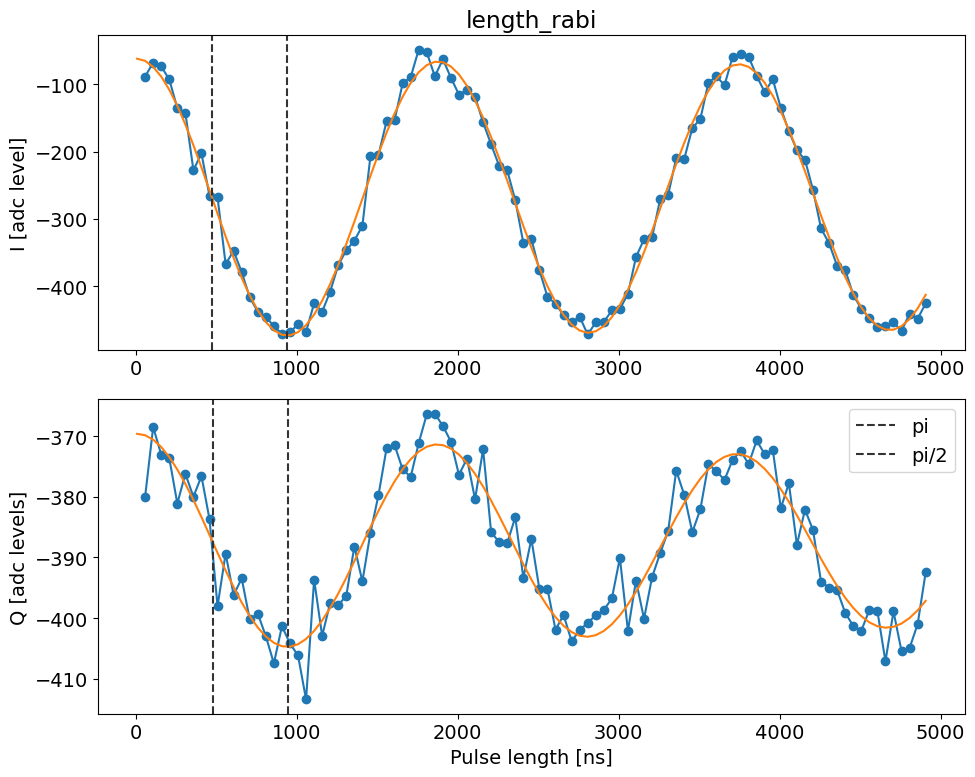

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-33-39_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=0.9410405802263471, pi2_length=0.47306227733780726, gain=3000
Running sideband general for manipulation mode 1 and storage mode 2


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00008_SidebandGeneralExperiment.h5
p1: 0.45367484576018036
p2: 94.05409582337583
Pi length: 1.0772883426981972
Pi/2 length: 0.526232884507434
p1: 0.4528477182640781
p2: 95.17114048080185
Pi length: 1.0724040362801677
Pi/2 length: 0.5203420739093813


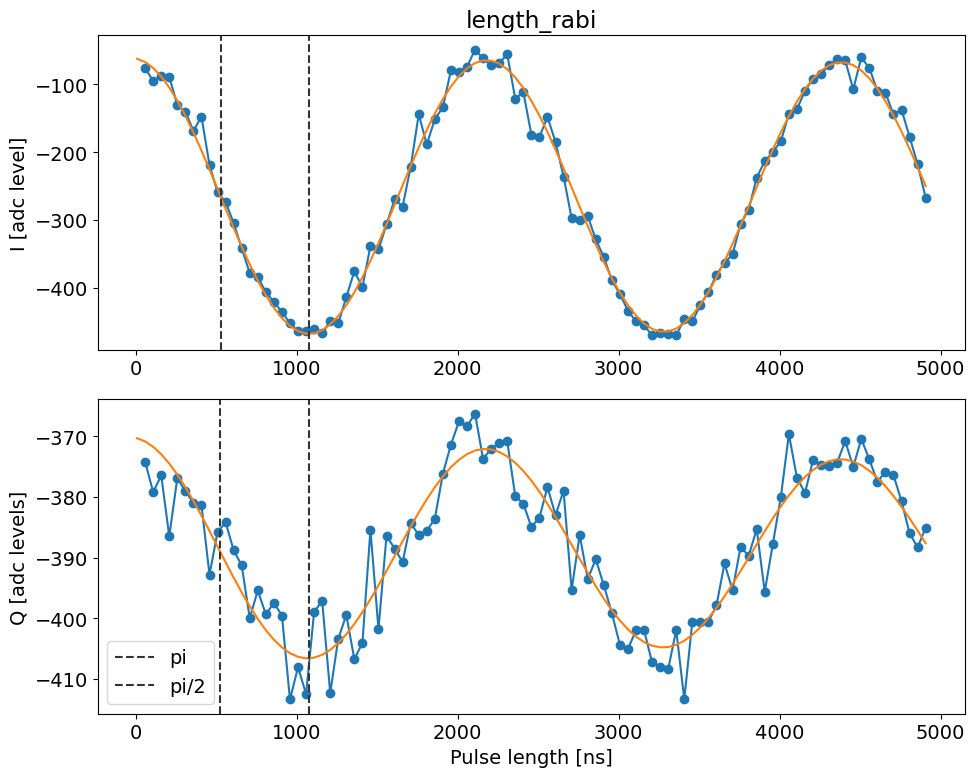

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-36-37_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=1.0772883426981972, pi2_length=0.526232884507434, gain=5000
Running sideband general for manipulation mode 1 and storage mode 3


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00009_SidebandGeneralExperiment.h5
p1: 0.3767204534570163
p2: 93.67430725602277
Pi length: 1.3001513097068342
Pi/2 length: 0.6365292586452374
p1: 0.3836355397797589
p2: 87.35872610285286
Pi length: 1.3224449231887552
Pi/2 length: 0.6707847559802573


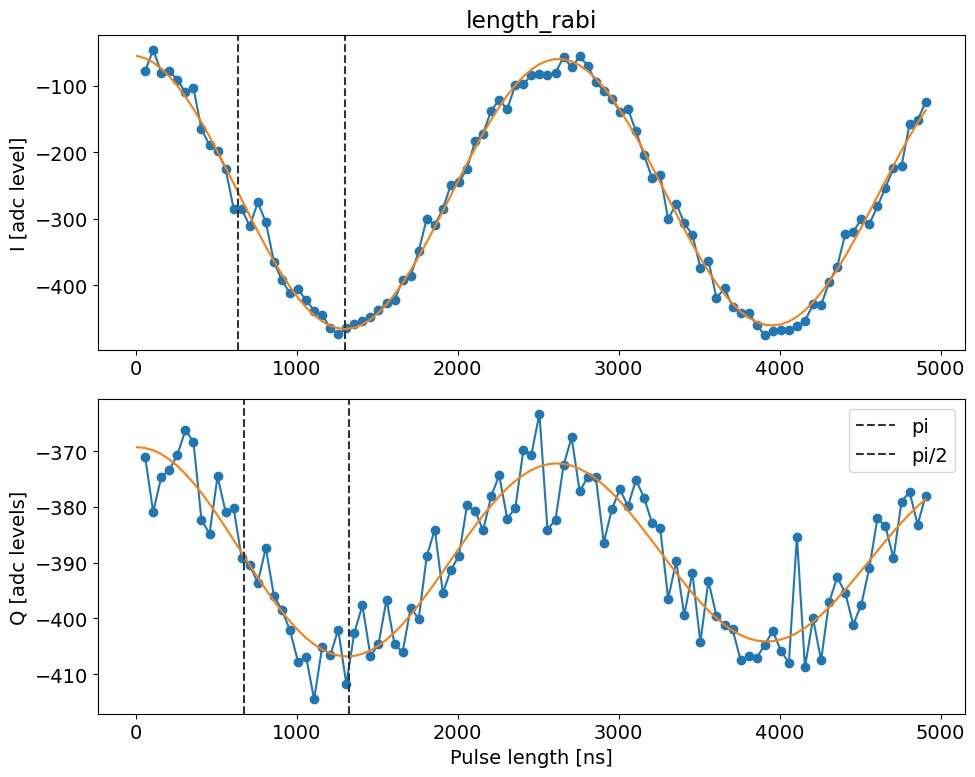

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-39-35_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=1.3001513097068342, pi2_length=0.6365292586452374, gain=9000
Running sideband general for manipulation mode 1 and storage mode 4


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00010_SidebandGeneralExperiment.h5
p1: 0.41152262972974424
p2: 92.42962229771693
Pi length: 1.1986000611848178
Pi/2 length: 0.5911000552576094
p1: 0.40681118396847654
p2: 96.07457554059134
Pi length: 1.187593158921978
Pi/2 length: 0.5730574483713744


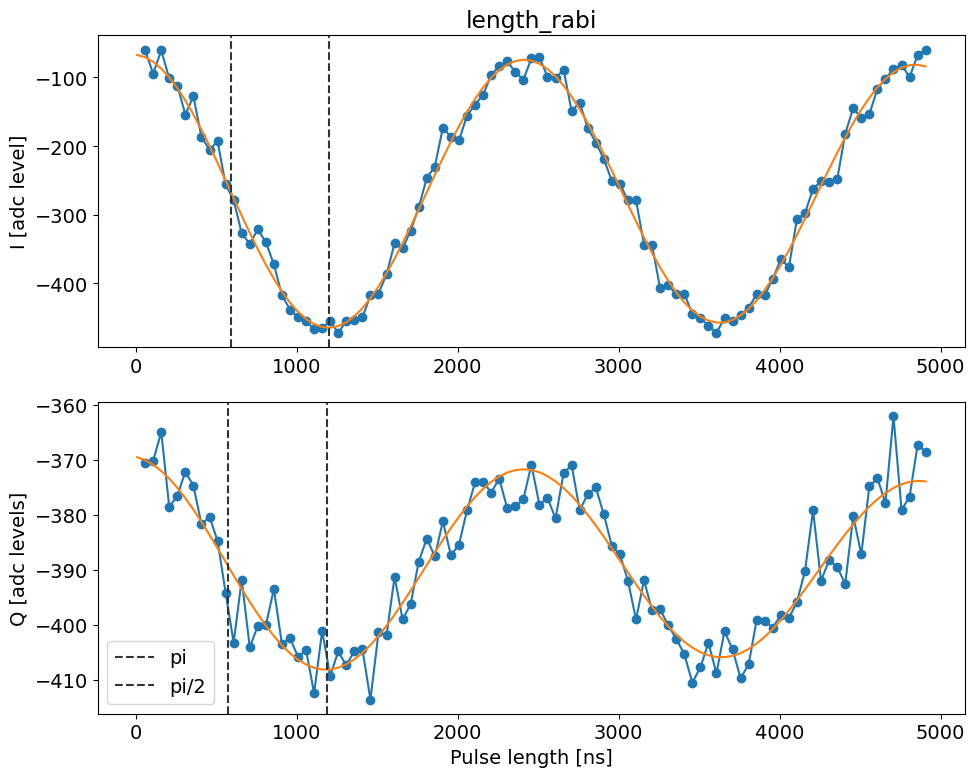

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-42-34_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=1.1986000611848178, pi2_length=0.5911000552576094, gain=9000
Running sideband general for manipulation mode 1 and storage mode 5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00011_SidebandGeneralExperiment.h5
p1: 0.31760554057583346
p2: 89.39499670191697
Pi length: 1.5795711995682677
Pi/2 length: 0.7924312789398729
p1: 0.31617042395558925
p2: 91.59710328008087
Pi length: 1.567393925718316
Pi/2 length: 0.7766811295235773


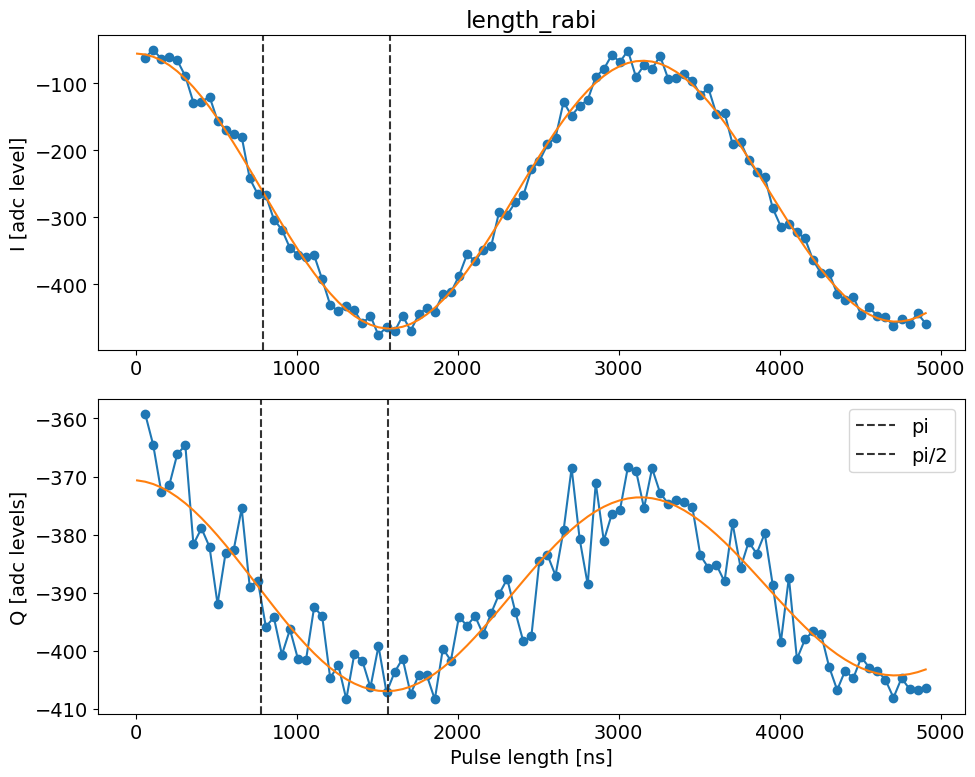

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-45-32_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=1.5795711995682677, pi2_length=0.7924312789398729, gain=7500
Running sideband general for manipulation mode 1 and storage mode 6


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00012_SidebandGeneralExperiment.h5
p1: 0.4036777350422954
p2: 86.70751885198648
Pi length: 1.2612679292638183
Pi/2 length: 0.6419620367210794
p1: 0.3953720803150732
p2: 95.83933483932285
Pi length: 1.2236059386408873
Pi/2 length: 0.5912901721842011


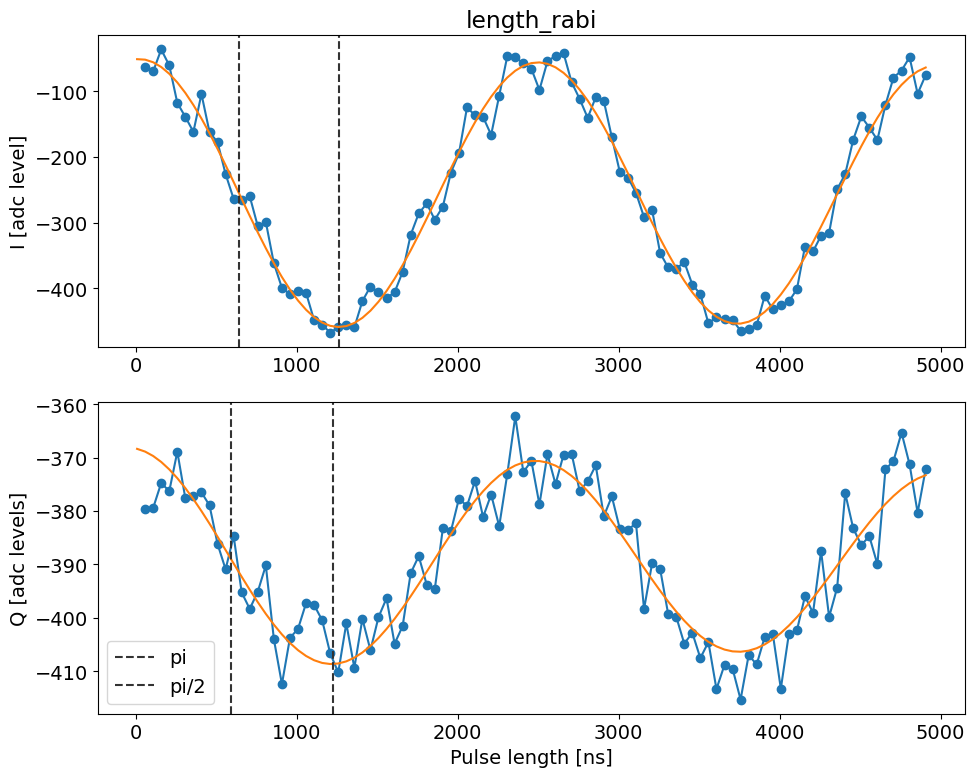

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-48-30_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=1.2612679292638183, pi2_length=0.6419620367210794, gain=13500
Running sideband general for manipulation mode 1 and storage mode 7


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00013_SidebandGeneralExperiment.h5
p1: 0.2268491825376934
p2: 89.72593624382677
Pi length: 2.2074634901026613
Pi/2 length: 1.1054097061598436
p1: 0.2236459449646579
p2: 94.81212751653403
Pi length: 2.1759079029921153
Pi/2 length: 1.0580696160537728


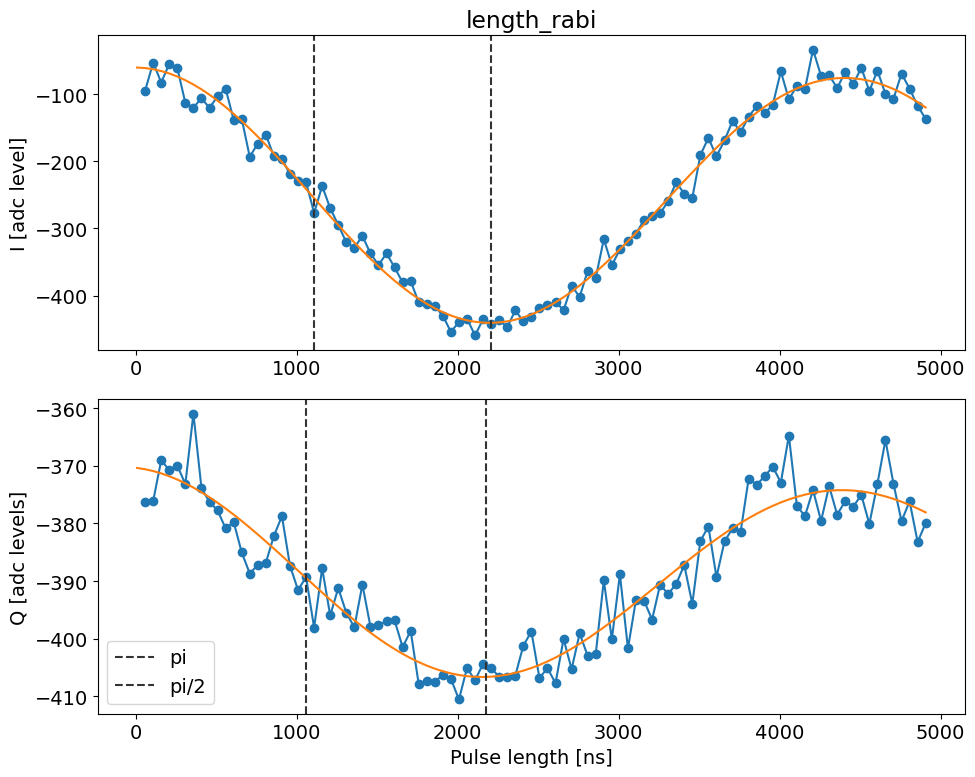

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-08_22-51-28_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-08.md
Updated configuration and dataset: pi_length=2.2074634901026613, pi2_length=1.1054097061598436, gain=10000


In [30]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [ ]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

19

In [ ]:
# config_thisrun.device.storage.ramp_sigma
# man_mode_no = 1
# stor_mode_no = 7
# req = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
# print("man_mode_no:", man_mode_no)
# print("stor_mode_no:", stor_mode_no)
# print("freq:", req)
# print("gain:", gain)
# print("hpi_length:", hpi_length)

In [ ]:

def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_thisrun, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_thisrun directly
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis


In [ ]:
if expts_to_run['RB']:
    storage_rbs = [None] * len(expts_to_run['stor_modes'])
    for i in range(len(expts_to_run['stor_modes'])):
        print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
        storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
            config_thisrun,
            ds_thisrun,
            expt_path,
            config_path,
            exp_param_file=exp_param_file,
            man_mode_no=1,
            stor_mode_no=i + 1
        )

In [ ]:
# from multimode_expts.fit_display_classes import MM_DualRailRBFitting
# dir_no = np.arange(72, 80, 1 )
# for idx, dir_no in enumerate(dir_no):
#     prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
#     dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
#     dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
#     filepath = dir_path
#     # Initialize RB analysis
#     rb_analysis = MM_DualRailRBFitting(
#         filename=None,
#         file_prefix=prefix,
#         config=yaml_cfg,
#         expt_path=expt_path,
#         title=f"M1-S{idx + 1} RB Analysis",
#         prev_data=prev_data,
#         dir_path=filepath
#     )
#     rb_analysis.show_rb(save_fig=True)



In [ ]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [ ]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

[3569.4263053206314]

In [ ]:
# storage_rb

In [ ]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [ ]:
expt_test.data = {}
f = expt_test.save_data()

In [ ]:
if expts_to_run['RB']:
    filename = expt_test.fname
    #create a directory with the filename but no .h5 extension
    import os
    directory = filename
    if directory.lower().endswith('.h5'):
        directory = directory[:-3]
    if not os.path.exists(directory):
        # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
        # Make sure the directory name does not have a .h5 extension
        os.makedirs(directory)

In [ ]:
directory
filename_only = os.path.basename(expt_test.fname)
filename_only

'00003_yoyoyo.h5'

In [ ]:
if expts_to_run['RB']:
    from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                    config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                    prev_data= prev_data)
    rb_analysis.show_rb()

In [ ]:
if expts_to_run['RB']:
    temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [ ]:
attrs['config'].keys()

dict_keys(['device', 'hw', 'aliases', 'data_management', 'expt', 'qubits', 'reps', 'single_shot_bef_expt', 'singleshot_reps', 'span', 'active_reset', 'man_reset', 'storage_reset', 'threshold', 'readout_per_round', 'rb_active_reset', 'rb_man_reset', 'rb_storage_reset', 'rb_reps', 'gates_per_wait', 'parity_meas', 'reset_qubit_after_parity', 'reset_qubit_via_active_reset_after_first_meas', 'rounds', 'variations', 'rb_depth', 'IRB_gate_no', 'postselection_delay', 'bs_repeat', 'sync', 'setup', 'bs_para', 'prepulse', 'postpulse', 'f0g1_offset', 'pre_sweep_pulse', 'ram_prepulse', 'ram_prepulse_strs', 'running_list'])

In [ ]:
temp_data.keys()

dict_keys(['Idata', 'Ie', 'Ig', 'Qdata', 'Qe', 'Qg', 'angle', 'confusion_matrix', 'fids', 'sequences', 'thresholds'])

In [ ]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

Number of entries in 'Idata': 10


In [ ]:
temp_data['sequences']

array([[ 6.,  3.,  2., ...,  3.,  3.,  4.],
       [ 2.,  5.,  6., ...,  2.,  5.,  6.],
       [ 2.,  5.,  5., ...,  1.,  1.,  6.],
       ...,
       [ 1.,  5.,  6., ...,  2.,  2., nan],
       [ 5.,  4.,  4., ...,  4.,  1.,  4.],
       [ 4.,  3.,  4., ...,  6.,  4.,  3.]])

# Shock TLS Function

In [ ]:
from multimode_expts.experiments.single_qubit.pulse_probe_f0g1_spectroscopy import PulseProbeF0g1SpectroscopyExperiment

def do_pulse_probe_f0g1_spectroscopy(config_thisrun, expt_path, config_path, 
                                     start=2007, step=0.02, expts=300, reps=100,
                                       rounds=1, length=1, gain=5000, pulse_type='gaussian',
                                         qubit_f=True, qubits=[0], prepulse=False, pre_sweep_pulse=None):
    """
    Run the PulseProbeF0g1SpectroscopyExperiment with specified parameters.
    """
    
    expt = PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )
    expt.cfg = AttrDict(deepcopy(config_thisrun))
    expt.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        pulse_type=pulse_type,
        qubit_f=qubit_f,
        qubits=qubits,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse
    )
    expt.cfg.device.readout.relax_delay = [5]  # Wait time between experiments [us]
    expt.go(analyze=True, display=True, progress=True, save=True)
    return expt

In [ ]:
# t2ramsey_ge_check = None
# while True: 
#     #close previous plots 
#     # import matplotlib.pyplot as plt
#     #each iteration is 5 minutes
#     # do_pulse_probe_f0g1_spectroscopy(
#     #     config_thisrun, expt_path, config_path,
#     #     start=3300, step=0.04, expts=10000, reps=100,
#     #     rounds=5, length=50, gain=30000, pulse_type='gaussian',
#     #     qubit_f=False, qubits=[0], prepulse=False, pre_sweep_pulse=None
#     # )

#     do_pulse_probe_ge(config_thisrun, start = 3300, 
#                       step = 0.04, expts = 10000, reps = 100, rounds = 5,
#                       length = 50, gain = 30000)
#     from IPython.display import clear_output
#     # from multimode_expts.fit_display_classes import SidebandFitting
#     clear_output(wait=True)
#     plt.close('all')  # Close all existing figures
#     t2ramsey_ge_check = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
#     t2ramsey_ge_check.analyze()
#     t2ramsey_ge_check.display(title_str='T2_ge_TLS')


In [ ]:
from multimode_expts.MM_base import MMAveragerProgram
from multimode_expts.experiments.qsim.utils import ensure_list_in_cfg

class ShockTLSProgram(MMAveragerProgram):
    def initialize(self):
        self.MM_base_initialize()
        
        
    def body(self):
        self.reset_and_sync()

        self.setup_and_pulse(
            ch=0,
            style='const',
            freq=self.freq2reg(1918, gen_ch=0),
            length=50,
            phase=0,
            gain=30000,
        )
    def update(self):
        self.mathi(self.q_rp, self.r_freq2, self.r_freq2, '+', self.f_step) # update frequency list index


class ShockTLSExperiment(Experiment):
    def acquire(self, progress):
        ensure_list_in_cfg(self.cfg)
        
        self.prog = ShockTLSProgram(soccfg=self.soccfg, cfg=self.cfg)
        self.prog.acquire(self.im[self.cfg.aliases.soc],
                         threshold=None,
                         load_pulses=True,
                         progress=progress,
                         debug=False)
    

### ShockTLS !!!

In [ ]:
shockTLS_bool = False # Set to FALSE to avoid running!!!!!!
if shockTLS_bool:    
    scktls = ShockTLSExperiment(soccfg=soc, path=expt_path, prefix='shockTLS',
                            config_file=config_path)
    scktls.cfg = AttrDict(deepcopy(config_thisrun))

    scktls.cfg.expt = dict(expts=2000, reps=2000, rounds=100000, qubit=[0])

    scktls.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    for kk in range(50):
        scktls.go(analyze=False, display=False, progress=True, save=False)

# Update Config and Dataset

In [38]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset comparison for man1_storage_swap_dataset

In [31]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'freq (MHz)': new_value = 348.95434739378794, old_value = 348.9943473937886, difference = -0.04000000000064574
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 0.9410405802263471, old_value = 0.9174265564762912, difference = 0.023614023750055835
  Column 'h_pi (mus)': new_value = 0.47306227733780726, old_value = 0.4458429892040043, difference = 0.027219288133802977
In M1-S2:
  Column 'freq (MHz)': new_value = 520.4412744019078, old_value = 520.3612744019075, difference = 0.0800000000002683
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 1.0772883426981972, old_value = 1.084581933496189, difference = -0.007293590797991856
  Column 'h_pi (mus)': new_value = 0.526232884507434, old_value = 0.5394664676927948, difference = -0.013233583185360831
In M1-S3:
  Column 'freq (MHz)': new_value = 696.1546768196094, old_value = 696.0946768196092, differenc

In [49]:
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.994347              NaN   0.917427    0.445843   
1      M1-S2   520.361274              NaN   1.084582    0.539466   
2      M1-S3   696.094677              NaN   1.314576    0.658091   
3      M1-S4   874.815379              NaN   1.221390    0.613439   
4      M1-S5  1053.097573              NaN   1.595772    0.802749   
5      M1-S6  1245.006393              NaN   1.253407    0.619833   
6      M1-S7  1422.461718              NaN   2.293646    1.144853   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2005.850000              NaN   1.079883    0.530253   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.426206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-06-30 02:15:15.104235  
1               5000  2025-06-30 02:18:13.425128  
2               9000  2025-06-30 02:21:12.434147  
3               9000  2025-06-30 02:24:10.686562  
4               7500  2025-06-30 02:27:09.054687  
5              13500  2025-06-30 02:30:07.599645  
6              10000  2025-06-30 02:33:06.360285  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-07-08 14:54:59.611517  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

### set TRUE to update dataset for man1_storage_swap_dataset

In [50]:
# stor new datset at old file path
updateDataset = True # Set to FALSE after this run!!!!!!
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    #save new dataset to curreent_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Old dataset saved to: H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\autocalibration_plots_2025-07-08\old_dataset_2025-07-08_14-56-26.h5
New dataset saved to old file path!


## Config comparison for hardware_config_202505

In [36]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.qubit.f_ge' differs:
  Old value (config1): 3567.3506008394015
  New value (config2): 3567.340096037547
Key 'device.qubit.f_ef' differs:
  Old value (config1): 3423.990931159239
  New value (config2): 3423.9707763531014
Key 'device.readout.phase' differs:
  Old value (config1): 73.4451705076109
  New value (config2): 73.69187754633023
Key 'device.readout.threshold' differs:
  Old value (config1): -283.43264261118475
  New value (config2): -298.9150578233093
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-283.43264261118475]
  New value (config2): [-298.9150578233093]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9912, 0.00880000000000003, 0.02039999999999999, 0.9796]
  New value (config2): [0.9911999999999994, 0.008800000000000585, 0.030818491094656796, 0.9691815089053432]
Key 'device.readout.Ie' differs:
  Old value (config1): 36.44400085547777
  New value (config2): 35.96504172330171


In [34]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

### set TRUE to update hardware_config!!

In [39]:
# Main logic
updateConfig_bool = True # Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.


# Loopbackprogram

In [ ]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [ ]:
GEN_CH = 5
RO_CH = 0
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 750, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soc, config)
iq_list = prog.acquire_decimated( soc = im[config_thisrun.aliases.soc], progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
iq_list

array([[[ -59.88,  -54.48,  -51.73,  -39.96,    6.08,  -94.19, -145.12,
          -40.71,  -17.64,   -9.21,   31.89,  -20.61,  -70.37,  -26.57,
          -16.32,  -27.12,  -19.08,  -21.08,  -25.4 ,  -11.75,    1.62,
            1.71,  -50.57, -108.6 ,  -67.5 ,  -51.78, -108.33,  -63.69,
            2.61,  -84.92, -291.14, -400.94, -409.57, -356.63, -245.07,
         -167.81, -206.63, -233.7 , -217.66, -232.1 , -133.56, -109.89,
         -213.81, -266.21, -124.95,  -28.63,  -44.13,   28.48,    1.95,
          -34.41,   22.88,  -16.92,  -19.76,   76.3 ,   76.59,   70.98,
           70.83,   24.47,   83.48,   91.38,   -5.27,  -45.32,   -6.56,
          -48.42,  -77.68,  -11.48,  -52.11,  -94.79,  -38.33,  -13.84,
            9.61,  -19.27,  -50.37,   19.52,  -17.38,  -77.31,  -74.5 ,
          -96.69,  -81.56,  -51.59,  -45.91,  -47.76,  -86.26, -119.14,
          -82.66,  -30.03,  -17.86, -112.47, -199.48, -193.01, -157.93,
          -92.17, -127.08, -190.46, -128.03,  -77.73,  -81.35,  

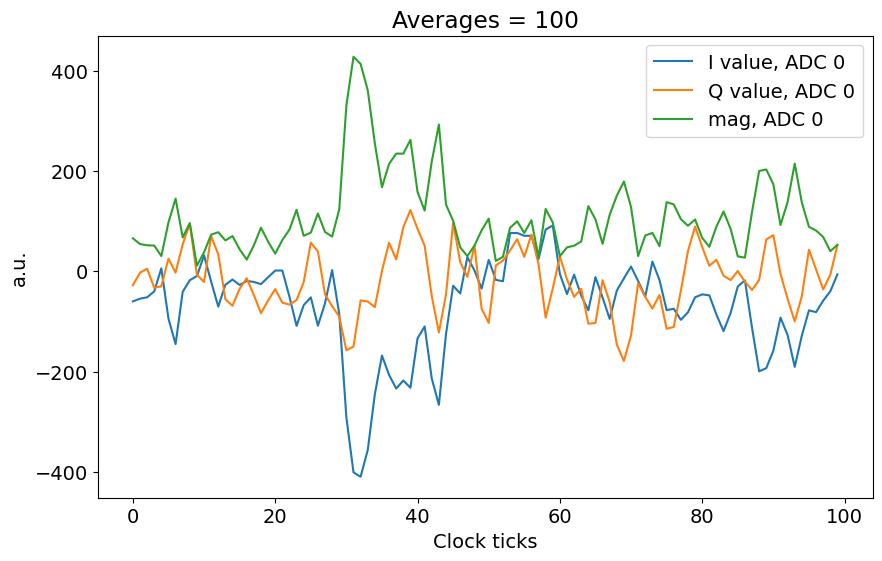

In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();